# Predicción Precios Argentina - MD 2022

Notebook para la competencias de [Kaggle](https://www.kaggle.com/competitions/fcen-md-2022-prediccion-precio-de-propiedades/leaderboard) de la materia MD de la maestria de DM de la UBA.

Autor: Tomás Delvechio

## Configuración de la notebook

A continuación se definen configuraciones que afectaran el resto del notebook.

In [666]:
# Libs estandar de pythons, utiles en todo el notebook
from datetime import date
import os.path
from shutil import which
import sys

# No tocar
EJECUTA_COLAB = 'google.colab' in sys.modules
ESTA_KAGGLE = not EJECUTA_COLAB \
    and which("kaggle") is not None \
    and os.path.exists(os.path.join(os.getenv("HOME"), ".kaggle/kaggle.json"))
#ENTORNO_DESARROLLO = "Desarrollo"
#ENTORNO_PRUEBA = "Prueba"
#ENTORNO_PRODUCCION = "Produccion"

In [667]:
if EJECUTA_COLAB:
    ! pip install numpy pandas matplotlib scipy scikit-learn nltk seaborn


In [668]:
# Libs de data science
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder


# Funciones para texto
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize


[nltk_data] Downloading package punkt to /home/tomas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tomas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tomas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Funciones generales

definición de algunas funciones que se utilizaran de forma general

In [669]:
def comparar_listas(l1, l2):
    """Compara la primer lista contra la segunda y retorna lo que le falta y lo que le sobra"""
    lo_que_le_falta = set(l2) - set(l1)
    lo_que_le_sobra = set(l1) - set(l2)
    return lo_que_le_falta, lo_que_le_sobra

def comparar_barrios(lista_barrios_uno, lista_barrios_dos):
    return comparar_listas(lista_barrios_uno, lista_barrios_dos)


def graficar_histogramas(df, columns, ds_type="entrenamiento"):
    for column in columns:
        ax = df[column].plot.hist()
        ax.set_title(f"Histograma de {column} - {ds_type}")
        ax.set_xlabel(f"Cantidad de {column}")
        plt.show()


def graficar_scatters(df, columns, ds_type="entrenamiento", son_fechas=False):
    #print(df[columns].corr()['rooms']['bedrooms'])
    correlations_df = df[columns].corr()
    for column_in_x in columns:
        for column_in_y in columns[columns.index(column_in_x)+1:]:
            #print(column_in_x, column_in_y)
            #print(np.corrcoef(column_in_x, column_in_y))
            if son_fechas:
                plt.plot_date(df[column_in_x], df[column_in_y])
            else:
                ax = plt.scatter(df[column_in_x], df[column_in_y])
                plt.title(f"Diagrama de dispersión entre {column_in_x} / {column_in_y} - {ds_type}")
                plt.text(-0.1, 0.7, f"r = {round(correlations_df[column_in_x][column_in_y], 3)}", fontsize=10, ha='center', va='center', transform=ax.transAxes)
                plt.xlabel(column_in_x)
                plt.ylabel(column_in_y)
            plt.show()


def graficar_correlograma(df, columns, annot=True):
    sns.heatmap(df[columns].corr(), annot=annot)


def ver_columnas(df, preffix='', suffix=''):
    print(preffix, df.columns, suffix)


def exploracion_precio(df, tipo_df="entrenamiento", plot=True):
    print(f"..:: Tipo de DF: {tipo_df} ::..")
    print(f"Tipo de dato de columna price: {df.price.dtype}")

    nans_en_price_col = df.price.isna().sum()
    print(
        f"Cantidad de NaNs en col price: {nans_en_price_col} ({nans_en_price_col*100/len(df)}%)")

    cantidad_ceros_en_price_col = df.price[df.price == 0].count()
    print(
        f"Cantidad de registros con valor Cero en price: {cantidad_ceros_en_price_col} ({cantidad_ceros_en_price_col*100/len(df)}%)")

    if tipo_df == "entrenamiento" and plot:
        #np.log2(df.price).plot.box()
        #df.price[df.price.notna()].plot.box()
        np.log2(df.price[df.price.notna() & (df.price != 0)]).plot.box()
        plt.show()
        np.log2(df.price[df.price.notna() & (df.price != 0)]).hist()
        plt.show()


def analisis_columna_currency(df, tipo_df="entrenamiento"):
    print(f"..:: Tipo de DF: {tipo_df} ::..")

    print(df.currency.dtype)
    print(df.currency.isna().sum())
    relative_freq_currency_table = df.currency.value_counts(
        normalize=True, )

    df[df.currency.isna(
    )]['price'].isna().sum() == df.price.isna().sum()
    #for currency_name, currency_rel_freq in df.currency.value_counts(normalize=True, ).items():
    #    df[df.currency == currency_name].value_counts()

    print(df[(df.currency.isna(
    )) & ~(df.price.isna())]["price"].count(), " currency en nan pero que tienen un precio")

    print('Monedas NO peso ni dolar=', df.currency.isin(['UYU', 'PEN', 'COP']).sum())
    print('Monedas NO peso ni dolar (%)=',
        df.currency.isin(['UYU', 'PEN', 'COP']).sum()*100 / len(df))
    
    print(df[(df.currency.isna()) & ~(df.price.isna())]["l1"].value_counts())
    
    ax = relative_freq_currency_table.plot.bar(rot=0, title=f"Distribución de currency en {tipo_df}")
    ax.bar_label(ax.bar(
        relative_freq_currency_table.index, relative_freq_currency_table.values.tolist()))
    plt.show()


def analisis_operaciones_propiedades(df, tipo_df="entrenamiento"):
    print(df.operation_type.value_counts())
    _ = df.property_type.value_counts().plot.bar(
        rot=45, title=f"Frecuencia segun Tipos de propiedad - {tipo_df}")
    plt.show()

    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_title(
        f"Tabla de Contingencia normalizada entre operation_type y property_type ({tipo_df})")
    sns.heatmap(pd.crosstab(df.operation_type,
                df.property_type,  normalize=True), annot=True, ax=ax)


def plot_nans(df, title="NaNs presentes en DF"):
    ax = plt.axes()
    sns.heatmap(df.isnull(), cbar=False, ax=ax)
    ax.set_title(title)
    plt.show()


def plot_correlogramas(df, title="Correlograma para el DF"):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(title)
    sns.heatmap(df[df.columns.drop('price')].corr(), annot=True, ax=ax)
    plt.show()


## Configuraciones editables

Estas variables pueden ser editadas para cambiar comportamientos del notebook

In [670]:
# Editar para cambiar comportamiento
#ENTORNO = ENTORNO_PRUEBA
ELIMINAR_COLS_CON_NAN_PROPORCION = 0.49 # Proporción mínima de NaNs presentes para eliminar una columna
DEBUG = False # En False evita un poco de verborragia en ciertas partes, no afecta en nada al procesamiento

## Datasets

Se listan todos los datasets a considerar a continuación en un dict

In [671]:
datasets_ref = {

    "input": {

        # Dataset de entrenamiento
        "entrenamiento": {
            "nombre": "properati_ar",
            "archivo": 'ar_properties.csv',
            "archivo_comprimido": "ar_properties.csv.gz",
            "comprimido": "gz",
            "url": "https://storage.googleapis.com/properati-data-public/ar_properties.csv.gz",
        },

        # Dataset de prueba
        "prueba": {
            "nombre": "testing",
            "archivo": "a_predecir.csv",
            "archivo_comprimido": "a_predecir.csv.zip",
            "comprimido": "zip",
            "url": "http://tomasdelvechio.github.io/subjects/dm/a_predecir.csv.zip",
        },

    },

    "output": {

        # Dataset de la fase de Limpieza inicial
        "dataset_limpio": {
            "nombre": "dataset_limpio",
            "archivo": "dataset_limpio.csv",
            "comprimido": False,
            "url": None,
        },

        # Dataset para subir a Kaggle
        "solucion": {
            "nombre": "soluciones",
            "archivo": "solucion.csv",
            "comprimido": False,
            "url": None,
        },

    },

}

### Descarga de los datasets

Controla si los datasets estan o no descargado, en caso de no estarlo, los descarga y descomprime

In [672]:
if EJECUTA_COLAB:
    DOWNLOAD_PATH = '/content'
else:
    DOWNLOAD_PATH = '.data/'
    # tratamos de crear el dir por si es la 1era vez que ejecuta
    ! mkdir -p $DOWNLOAD_PATH

for tipo, ds in datasets_ref["input"].items():
    print(f"Verificando ds para {tipo}: {ds['nombre']}")

    fulllpath = os.path.join(
        DOWNLOAD_PATH, f"{ds['archivo_comprimido']}")
    fulllpath_raw = os.path.join(
        DOWNLOAD_PATH, ds["archivo"])

    if os.path.exists(fulllpath_raw):
        # skip download
        print(f"    Dataset {ds['nombre']} ya descargado anteriormente... No se descarga.")
    else:
        url = ds["url"]
        print(f"Descargando {ds['nombre']} desde {url}")
        ! wget -N -O $fulllpath -q $url
        print(f"DS {ds['nombre']} descargado correctamente")
        if ds["comprimido"] == "gz":
            ! gzip -d -f $fulllpath
        elif ds["comprimido"] == "zip":
            ! unzip -n $fulllpath -d ".data/"
            ! rm $fulllpath

archivo_entrenamiento = os.path.join(
    DOWNLOAD_PATH, datasets_ref["input"]["entrenamiento"]["archivo"])
archivo_prueba = os.path.join(
    DOWNLOAD_PATH, datasets_ref["input"]["prueba"]["archivo"])


Verificando ds para entrenamiento: properati_ar
    Dataset properati_ar ya descargado anteriormente... No se descarga.
Verificando ds para prueba: testing
    Dataset testing ya descargado anteriormente... No se descarga.


Preparamos el archivo de salida

In [673]:
archivo_limpieza_inicial = os.path.join(
    DOWNLOAD_PATH, datasets_ref["output"]["dataset_limpio"]["archivo"])
archivo_salida = os.path.join(
    DOWNLOAD_PATH, datasets_ref["output"]["solucion"]["archivo"])

print(f"Archivo intermedio de limpieza inicial: {archivo_limpieza_inicial}")
print(f"Archivo de soluciones: {archivo_salida}")


Archivo intermedio de limpieza inicial: .data/dataset_limpio.csv
Archivo de soluciones: .data/solucion.csv


### Datos externos

In [674]:
# barrios caba segun el gcba
barrios_caba = [
    "Agronomía",
    "Almagro",
    "Balvanera",
    "Barracas",
    "Belgrano",
    "Boedo",
    "Caballito",
    "Chacarita",
    "Coghlan",
    "Colegiales",
    "Constitución",
    "Flores",
    "Floresta",
    "Boca",
    "Paternal",
    "Liniers",
    "Mataderos",
    "Monte Castro",
    "Monserrat",
    "Nueva Pompeya",
    "Nuñez",
    "Palermo",
    "Parque Avellaneda",
    "Parque Chacabuco",
    "Parque Chas",
    "Parque Patricios",
    "Puerto Madero",
    "Recoleta",
    "Retiro",
    "Saavedra",
    "San Cristobal",
    "San Nicolás",
    "San Telmo",
    "Versalles",
    "Villa Crespo",
    "Villa Devoto",
    "Villa General Mitre",
    "Villa Lugano",
    "Villa Luro",
    "Villa Ortuzar",
    "Villa Pueyrredon",
    "Villa Real",
    "Villa Riachuelo",
    "Villa Santa Rita",
    "Villa Soldati",
    "Villa Urquiza",
    "Villa del Parque",
    "Vélez Sarsfield",
]

In [675]:
columnas_id = ["id", "ad_type", ]
columnas_fecha = ["start_date", "end_date", "created_on", ]
columnas_ubicacion = [
    "lat",
    "lon",
    "l1",
    "l2",
    "l3",
    "l4",
    "l5",
    "l6",
]
columnas_publicacion = [
    "price",
    "currency",
    "price_period",
    "title",
    "description",
    "property_type",
    "operation_type",
]

columnas_de_propiedad = [
    'rooms',
    'bedrooms',
    'bathrooms',
    'surface_total',
    'surface_covered',
]


# Análisis del conjunto de datos

Se analizan ambos datasets para conocerlos y caracterizarlos, ahora que el dataset de entrenamiento se encuentra limpio de registros que no tienen nada que ver con la tarea de predicción a realizar.

In [676]:
df_entrenamiento_inicial = pd.read_csv(
    archivo_limpieza_inicial, parse_dates=columnas_fecha)
df_prueba_inicial = pd.read_csv(
    archivo_prueba, parse_dates=columnas_fecha)


## Estudio de dataset de prueba

Se analiza este dataset en mayor profundidad que la sección anterior a fin de determinar cual es la población a predecir. Esto definira algunas estrategias de limpieza de datos.

### Análisis del dataset segun barrios

In [677]:
df_prueba_inicial.l3.value_counts(normalize=True)


Palermo                0.188592
Belgrano               0.101196
Recoleta               0.089236
Caballito              0.068077
Villa Crespo           0.053358
Almagro                0.052438
Barracas               0.035879
Nuñez                  0.033119
Flores                 0.033119
Villa Urquiza          0.031279
Balvanera              0.031279
Colegiales             0.024839
San Telmo              0.022079
Saavedra               0.020239
Boedo                  0.018399
Villa Devoto           0.015639
Monserrat              0.015639
San Nicolás            0.014719
Puerto Madero          0.013799
Floresta               0.012879
Villa del Parque       0.011040
Paternal               0.009200
San Cristobal          0.009200
Villa Ortuzar          0.008280
Parque Patricios       0.008280
Constitución           0.007360
Villa Luro             0.005520
Monte Castro           0.005520
Chacarita              0.005520
Retiro                 0.004600
Villa General Mitre    0.004600
Parque C

¿Cuantos barrios estan presentes? ¿Existen registros que no esten en barrios verdaderos?

In [678]:
barrios_de_menos, barrios_que_no = comparar_barrios(df_prueba_inicial.l3.unique(), barrios_caba)
print("Los siguientes barrios no tiene datos en Properatti **Pruebas**", barrios_de_menos)
print("Los siguientes barrios que SI estan Properatti **Pruebas** no son barrios de CABA en realidad", barrios_que_no)


Los siguientes barrios no tiene datos en Properatti **Pruebas** {'Villa Soldati', 'Villa Riachuelo'}
Los siguientes barrios que SI estan Properatti **Pruebas** no son barrios de CABA en realidad {'2 Ambientes', 'GBA Norte'}


2 cosas hay que hacer con esta información:

- Los barrios que no estén en pruebas, hay que volarlos de entrenamiento (si estuvieran)
- Los barrios que no son, hay que controlar que tengan sentido e imputarles algun valor en testing, o eliminarlos en el caso de training

In [679]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

df_prueba_inicial[df_prueba_inicial.l3 == "GBA Norte"]

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type,details,additionals,services,l4,l5,l6
1009,1010,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.510875,-34.544037,Argentina,Capital Federal,GBA Norte,6.0,4.0,3.0,265.0,265.0,NaN,USD,NaN,"Melo Al 4000 - PH en Venta en Vicente López, Vicente López, GBA Norte, Provincia de Buenos Aires de 265 m2 con 4 dormitorios, 3 baños, a .","Vivienda multifamiliar con deposito , galpon, o taller, en inmejorable zona de Villa Martellli . <br>La propiedad se desarrolla sobre un lote irregular de 329 m2, contando en planta baja, al frente, con un taller de 110 m2 con baño .<br>En planta alta , PH de 3/4 amb con lavadero cubierto y terraza con parrilla, y al fondo, casa pequeña de 60 m2 aprox de 3 amb y jardin con parrilla.<br>La zona es muy accesible desde varios puntos, dado que dista solo a 7 cuadras de Colectora mano CABA.<br>Gran oportunidad para proyecto familiar con espacio de trabajo o emprendimiento comercial con vivienda!<br>Se toman propiedades por la zona, en parte de pago, Se escuchan ofertas ! Oportunidad !! Visitala !!<br><br>Nota: La información gráfica y escrita contenida en el presente aviso es meramente a titulo estimativo y no forma parte de ningún tipo de documentación contractual. Las medidas y superficies definitivas surgirán del título de propiedad del inmueble referido. Asimismo los importes de tasas, servicios y expensas indicados están sujetos a verificación. El valor del inmueble indicado en el presente puede ser modificado sin previo aviso.",PH,Venta,"Superficie 265m2, Ambientes 6, Baños 3, Dormitorios 4, Sup. Cubierta 254m2, Antigüedad50 años","Aceptan Mascotas, Terraza","Gas, Luz",NaN,NaN,NaN


In [680]:
df_prueba_inicial[df_prueba_inicial.l3 == "2 Ambientes"]


,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type,details,additionals,services,l4,l5,l6
132,133,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.434555,-34.589963,Argentina,Capital Federal,2 Ambientes,2.0,1.0,1.0,51.0,51.0,NaN,USD,NaN,"Avenida Coronel Niceto Vega 5100 - PH en Venta en CABA de 51 m2 con 1 dormitorio, 1 baño, a .","Descripción básica: <br>- PH 2 ambientes de 50m2 con hermoso patio. <br>- Gran luminosidad.<br>- Edificio en muy buen estado.<br><br>Medidas de ambientes:<br>En la planta baja:<br>- Sala de estar 22,68 m2.<br>- Cocina 8,58 m2.<br>En la plata alta:<br>- Anexo 6 m2.<br>- Habitación 24,4 m2.<br>- Baño 3,6 m2.<br> <br>Estado del departamento:<br>- Refaccionado completamente a nuevo. <br> <br>Gastos: <br>-ABL :$400<br>-Expensas : $3.500<br><br>Calidad ambiental:<br>-Realmente muy luminoso ya que cuenta con amplios ventanales, tanto en la planta baja como en la planta alta de la propiedad. <br>- A pesar de estar en una zona muy transitada,por su disposición interna no se escuchan ruidos. <br>- Orientación oeste.<br><br>Calefacción y Refrigeración de Ambientes:<br>- Aire acondicionado frío/calor en la parte de arriba.<br>- Calefactor en la parte de abajo.<br><br>Descripción del Edificio: <br>- Buen estado general.<br><br>Portería:<br>- Limpieza tercerizada. <br><br>Entrega:<br>- Entrega inmediata<br>- Actualmente se encuentra habitado.<br>- La documentación de la propiedad está en condiciones para la compraventa<br><br>Otras aspectos a destacar de la propiedad:<br>-Cocina a gas.<br>- Calefon.<br>- Cocina abierta con barra desayunadora . <br>- Agrandaron la claraboya por lo que genera mucha más iluminación en la planta superior. <br>- La propiedad cuenta con un hermoso patio.<br><br>Accesibilidad:<br>- Colectivos : 34,39,55,108,140,151,166,168.<br>- A 1 cuadra de Avenida Córdoba , a 6 cuadras de Scalabrini Ortiz . <br><br>Descripción del barrio:<br>- La propiedad se encuentra en el barrio de Palermo , que pertenece a la comuna 14 de la ciudad de Buenos Aires ,a pocos minutos de Plaza Italia, al ser un barrio turístico , con muchas opciones gastronómicas y locales comerciales .<br><br>------<br><br>Todas las propiedades publicadas en el perfil de ****** se encuentran a cargo de un profesional matriculado. La intermediación y la conclusión de las operaciones serán llevadas exclusivamente por la firma:<br><br>Carina Beccio<br>Lamac Propiedades<br>Matrícula: CUCICBA 5424",PH,Venta,"Superficie 51m2, Ambientes 2, Baños 1, Dormitorios 1, Sup. Cubierta 51m2, Apto profesionalSí, Antigüedad32 años, Orientación W",Patio,"Gas, Luz",NaN,NaN,NaN


In [681]:
pd.reset_option('display.max_columns')
pd.reset_option('max_colwidth')


De lo anterior, se puede deducir que el inmueble que tiene por error en el barrio el valor "2 Ambientes" es un inmueble de Palermo. El inmueble que esta en GBA Norte, se encuentra en Villa Martelli, no en CABA. Por cercania, se le va a imputar el barrio "Saavedra".

### Estudio de características de la propiedad

Nos referimos acá a las columnas que nos indican propiedades el inmueble en sí.

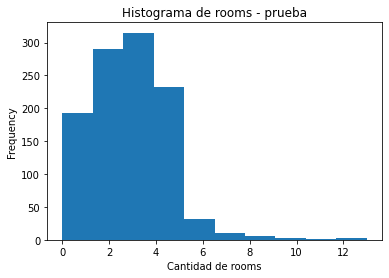

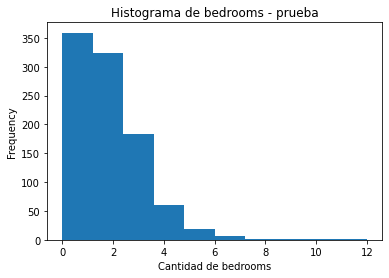

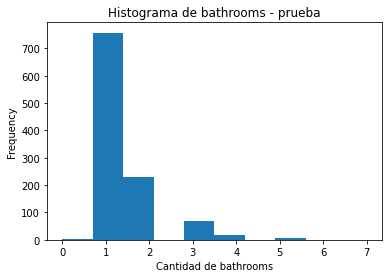

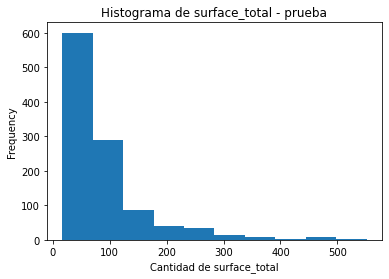

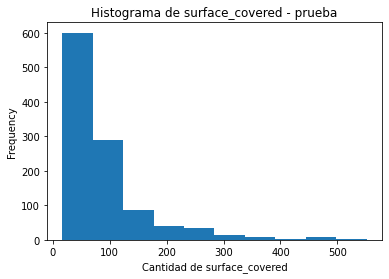

In [682]:
graficar_histogramas(df_prueba_inicial, columnas_de_propiedad, "prueba")
#graficar_scatters(df_prueba_inicial, columnas_de_propiedad, "prueba")


## Estudio de dataset de entrenamiento


### Estudio de Columnas de propiedad

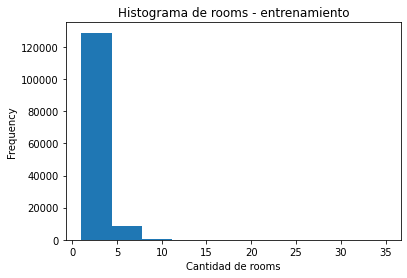

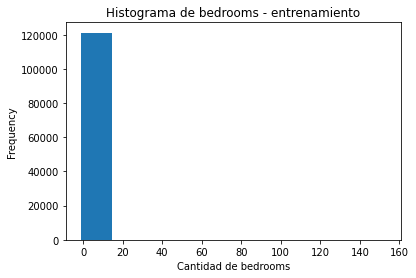

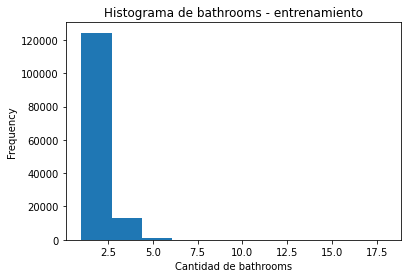

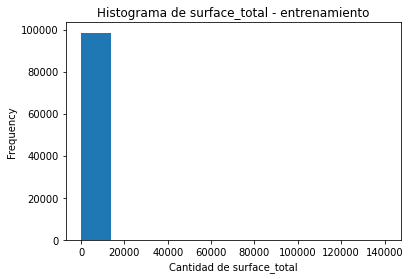

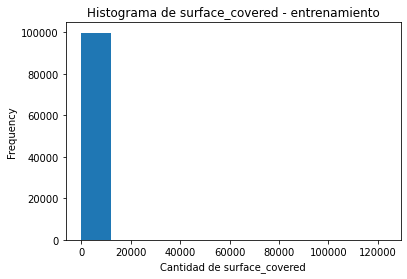

In [683]:
graficar_histogramas(df_entrenamiento_inicial, columnas_de_propiedad)
#graficar_scatters(df_entrenamiento_inicial, columnas_de_propiedad)


### Estudio de Barrios

In [684]:
barrios_de_menos, barrios_que_no = comparar_barrios(
    df_entrenamiento_inicial.l3.unique(), barrios_caba)
print("Los siguientes barrios no tiene datos en Properatti **Entrenamiento**", barrios_de_menos)
print("Los siguientes barrios que SI estan Properatti **Entrenamiento** no son barrios de CABA en realidad", barrios_que_no)


Los siguientes barrios no tiene datos en Properatti **Entrenamiento** {'Villa Pueyrredon', 'Vélez Sarsfield', 'Nueva Pompeya'}
Los siguientes barrios que SI estan Properatti **Entrenamiento** no son barrios de CABA en realidad {nan, 'Abasto', 'Catalinas', 'Tribunales', 'Las Cañitas', 'Once', 'Parque Centenario', 'Barrio Norte', 'Villa Pueyrredón', 'Pompeya', 'Congreso', 'Centro / Microcentro', 'Velez Sarsfield'}


In [685]:
barrios_de_menos, barrios_que_no = comparar_barrios(
    df_entrenamiento_inicial.l3.unique(), df_prueba_inicial.l3.unique())
print("Los siguientes barrios no tiene datos en Properatti **Entrenamiento** pero SI estan en Properatti **Prueba**", barrios_de_menos)
print("Los siguientes barrios que SI estan Properatti **Entrenamiento** pero no en Properatti **Prueba**", barrios_que_no)


Los siguientes barrios no tiene datos en Properatti **Entrenamiento** pero SI estan en Properatti **Prueba** {'Nueva Pompeya', '2 Ambientes', 'Vélez Sarsfield', 'GBA Norte', 'Villa Pueyrredon'}
Los siguientes barrios que SI estan Properatti **Entrenamiento** pero no en Properatti **Prueba** {nan, 'Abasto', 'Villa Riachuelo', 'Tribunales', 'Catalinas', 'Las Cañitas', 'Villa Soldati', 'Once', 'Parque Centenario', 'Barrio Norte', 'Villa Pueyrredón', 'Pompeya', 'Congreso', 'Centro / Microcentro', 'Velez Sarsfield'}


Se van a eliminar de entrenamiento los registros de los barrios que no estan en pruebas. Pero antes es necesario imputar los que si estan pero tienen otros nombres.

In [686]:
# en Pruebas col l3
#   GBA Norte imputar Saavedra
#   2 Ambientes imputar Palermo
df_prueba_inicial.replace({
    'GBA Norte': 'Saavedra',
    '2 Ambientes': 'Palermo',
}, inplace=True)

# conservamos los viejos valores antes de imputarlos
df_entrenamiento_inicial["l3_old"] = df_entrenamiento_inicial.l3

df_entrenamiento_inicial.l3.replace({
    'Pompeya': 'Nueva Pompeya',
    'Villa Pueyrredón': 'Villa Pueyrredon',
    'Velez Sarsfield': 'Vélez Sarsfield',
    'Catalinas': 'Puerto Madero',
    'Abasto': 'Balvanera',
    'Centro / Microcentro': 'San Nicolás',
    'Parque Centenario': 'Caballito',
    'Las Cañitas': 'Palermo',
    'Barrio Norte': 'Recoleta',
    'Tribunales': 'San Nicolás',
    'Congreso': 'Balvanera',
    'Once': 'Balvanera',
    #'': '',
}, inplace=True)


In [687]:
df_entrenamiento_inicial.l3[df_entrenamiento_inicial.l3 == "Barrio Norte"]


Series([], Name: l3, dtype: object)

Entonces, ahora se eliminan publicaciones que tengan su barrio en NaN, en Villa Soldati o Villa Riachuelo

In [688]:
print(df_entrenamiento_inicial.l3.isna().sum())
print((df_entrenamiento_inicial.l3 == "Villa Soldati").sum())
print((df_entrenamiento_inicial.l3 == "Villa Riachuelo").sum())

# Se eliminan de entrenamiento los barrios nan, "Villa Soldati" y "Villa Riachuelo"
print(len(df_entrenamiento_inicial))
df_entrenamiento_inicial = df_entrenamiento_inicial[~df_entrenamiento_inicial.l3.isin(['Villa Soldati', 'Villa Riachuelo'])]
print(len(df_entrenamiento_inicial))
df_entrenamiento_inicial = df_entrenamiento_inicial[df_entrenamiento_inicial.l3.notna()]
print(len(df_entrenamiento_inicial))


565
67
21
145188
145100
144535


En este punto, tenemos un dataset con la información de los barrios de CABA. Para continuar, debemos revisar algunas métricas explorando barrios en entrenamiento y pruebas.

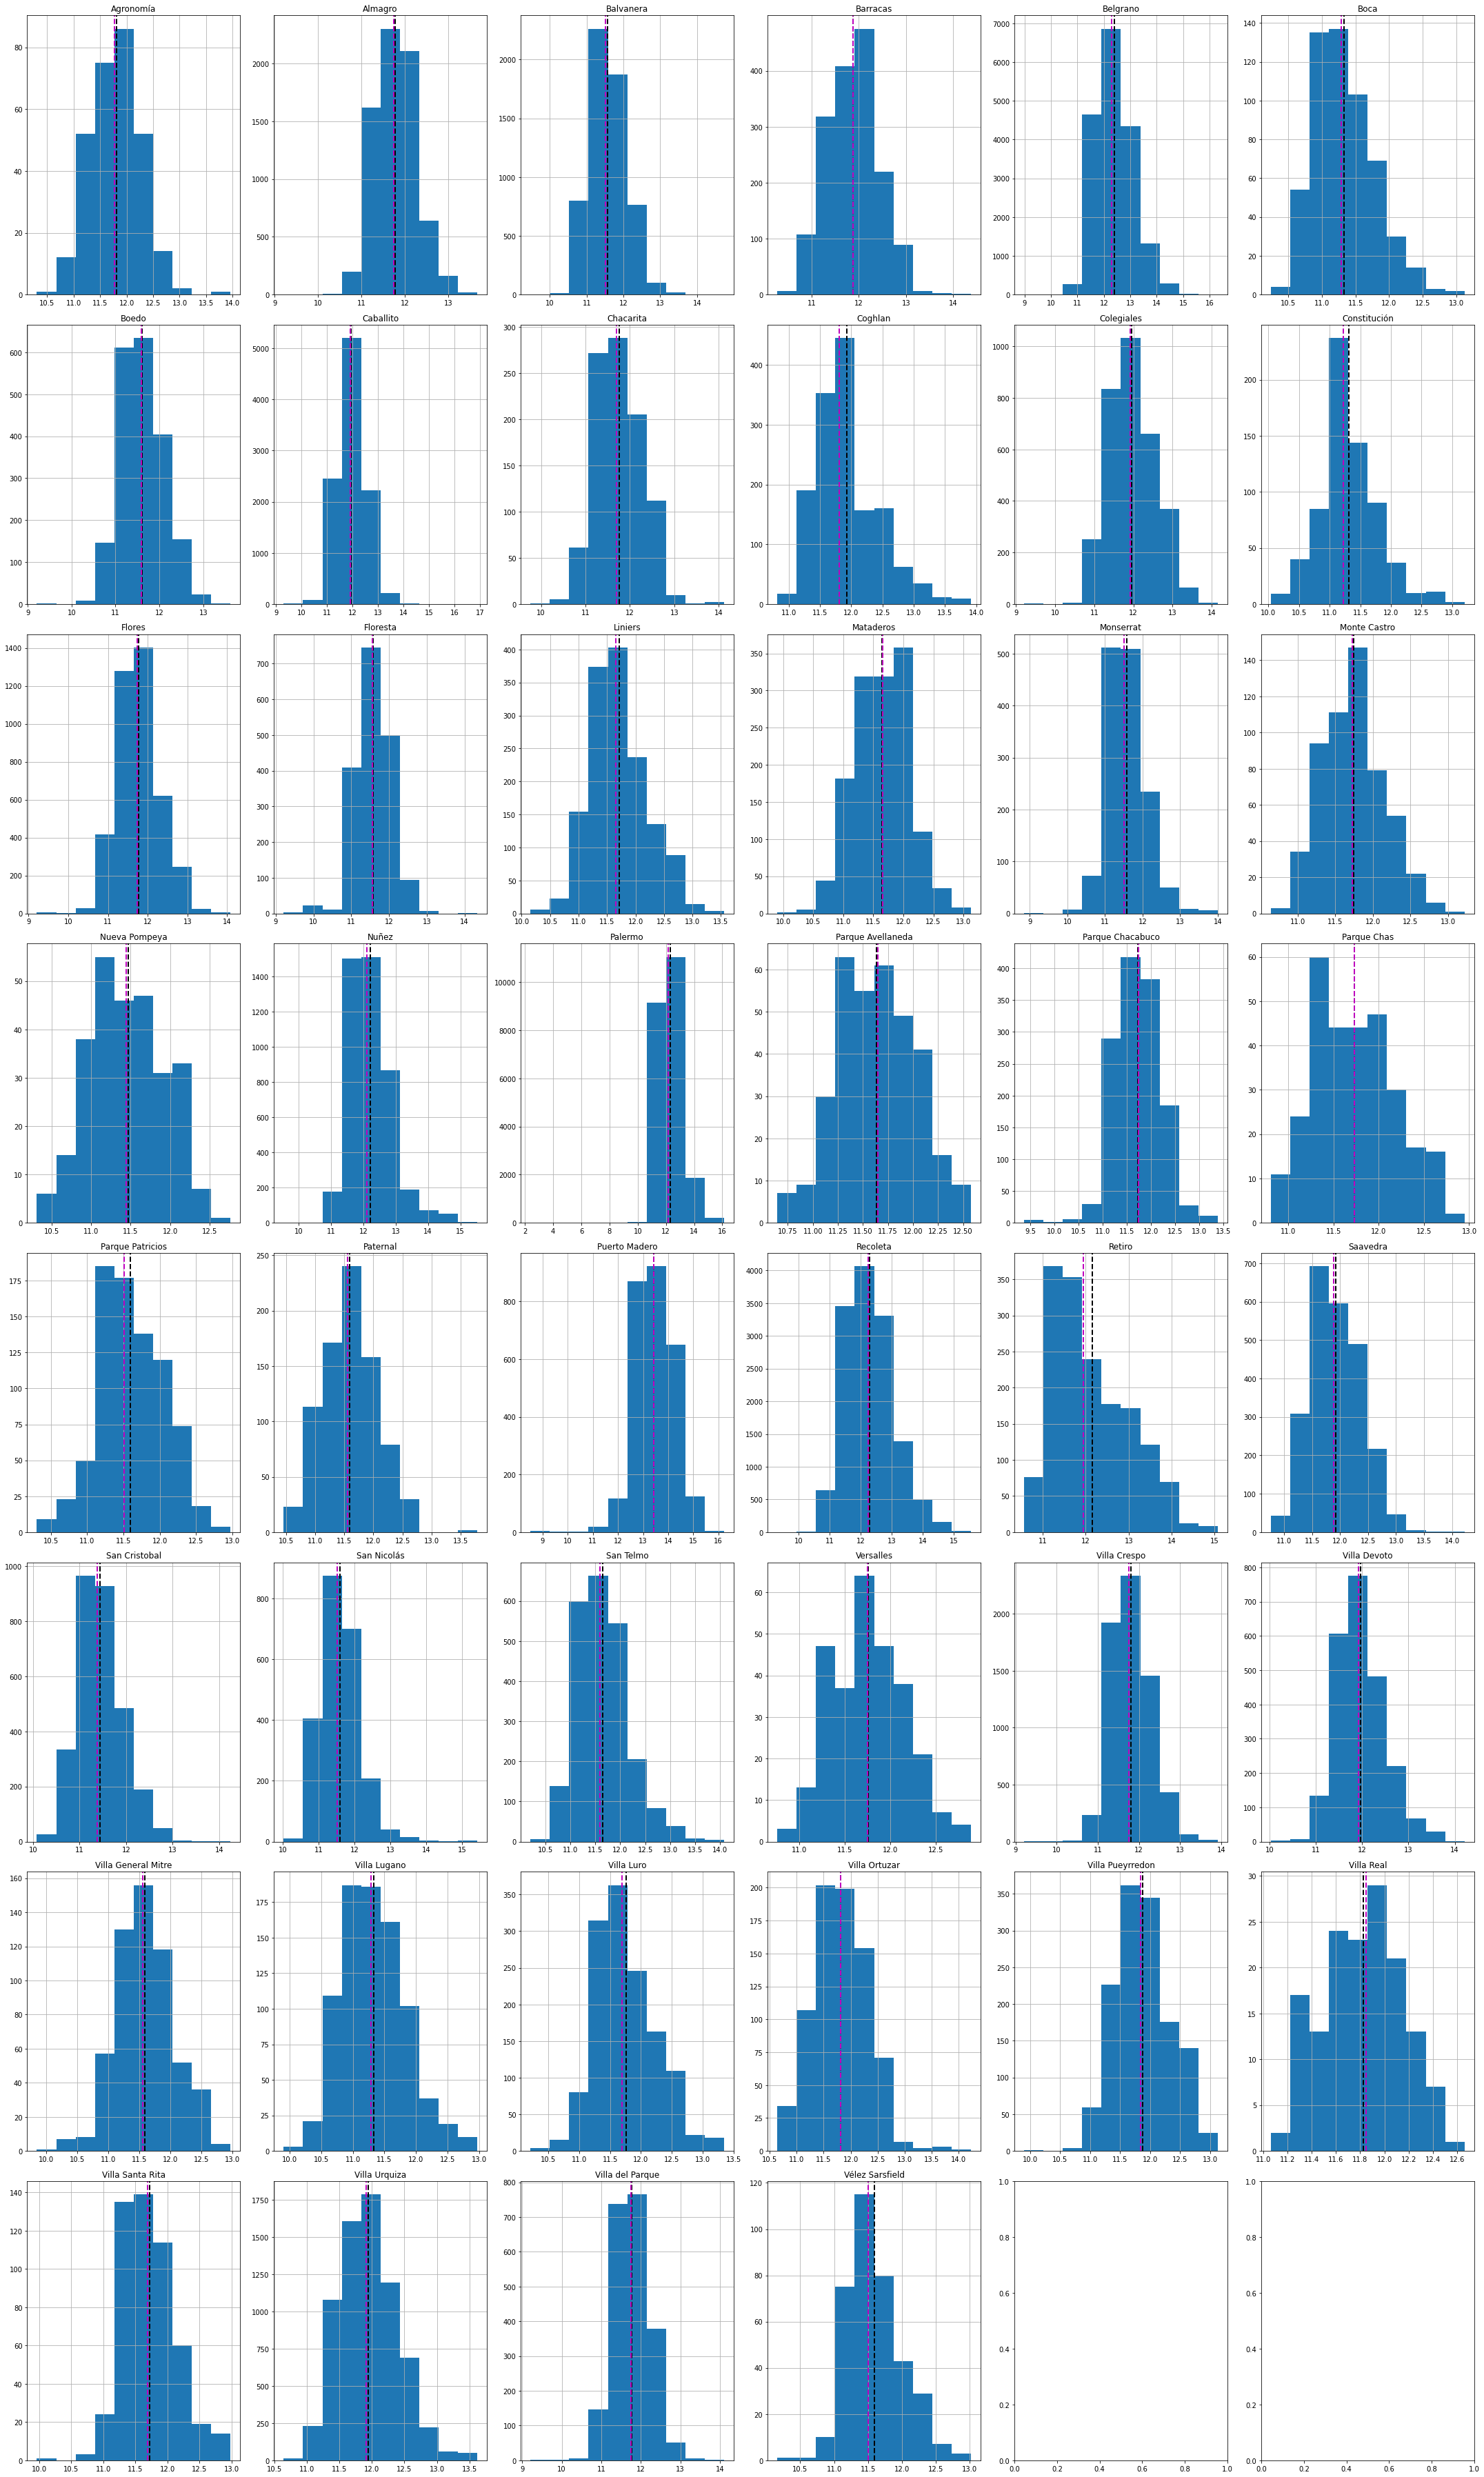

In [689]:
fig, axes = plt.subplots(8, 6, figsize=(30, 50))
axe = axes.ravel()
i=0
for barrio, df_barrio in df_entrenamiento_inicial.groupby('l3'):
    axe[i].set_title(barrio)
    #np.log(df_barrio.price).hist(ax=axe[i])
    np.log(df_barrio.price).hist(ax=axe[i])
    axe[i].axvline(np.log(df_barrio.price).mean(), color='k',
                   linestyle='dashed', linewidth=2)
    axe[i].axvline(np.log(df_barrio.price).median(), color='m',
                   linestyle='dashed', linewidth=2)
    i += 1
fig.tight_layout()
plt.show()


### Estudio de columnas de ubicación

A continuación se estudian los valores relacionados a las columnas de ubicación

In [690]:
print(df_entrenamiento_inicial[columnas_ubicacion].head())
df_entrenamiento_inicial[columnas_ubicacion].tail()


         lat        lon         l1               l2       l3  \
0 -34.597364 -58.372987  Argentina  Capital Federal   Retiro   
1 -34.600004 -58.417191  Argentina  Capital Federal  Almagro   
2 -34.581699 -58.433547  Argentina  Capital Federal  Palermo   
3 -34.595044 -58.442538  Argentina  Capital Federal  Palermo   
4 -34.582549 -58.417350  Argentina  Capital Federal  Palermo   

                  l4  l5  l6  
0                NaN NaN NaN  
1                NaN NaN NaN  
2  Palermo Hollywood NaN NaN  
3                NaN NaN NaN  
4                NaN NaN NaN  


,lat,lon,l1,l2,l3,l4,l5,l6
145183,-34.585810,-58.405548,Argentina,Capital Federal,Recoleta,NaN,NaN,NaN
145184,-34.600052,-58.393015,Argentina,Capital Federal,Recoleta,NaN,NaN,NaN
145185,-34.613926,-58.499472,Argentina,Capital Federal,Monte Castro,NaN,NaN,NaN
145186,-34.573074,-58.419353,Argentina,Capital Federal,Palermo,NaN,NaN,NaN
145187,-34.563411,-58.445656,Argentina,Capital Federal,Belgrano,NaN,NaN,NaN


In [691]:
print("Colname - % de nulls")
df_entrenamiento_inicial[columnas_ubicacion].isna(
).sum() / len(df_entrenamiento_inicial)


Colname - % de nulls


lat    0.057682
lon    0.057682
l1     0.000000
l2     0.000000
l3     0.000000
l4     0.957443
l5     1.000000
l6     1.000000
dtype: float64

l4, l5 y l6 desaparecerán.

Miraremos a continuación la distribución de las columnas númericas.

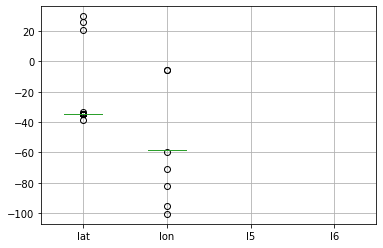

In [692]:
df_entrenamiento_inicial[columnas_ubicacion].boxplot();


### Estudio de columnas de fechas

A continuación se estudian los valores relacionados a las columnas de fechas

In [693]:
df_entrenamiento_inicial[columnas_fecha].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144535 entries, 0 to 145187
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   start_date  144535 non-null  datetime64[ns]
 1   end_date    144535 non-null  datetime64[ns]
 2   created_on  144535 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 4.4 MB


In [694]:
df_entrenamiento_inicial[columnas_fecha].head()


,start_date,end_date,created_on
0,2020-08-22,2020-09-04,2020-08-22
1,2020-08-22,2020-09-04,2020-08-22
2,2020-08-22,2020-09-04,2020-08-22
3,2020-08-22,2020-09-04,2020-08-22
4,2020-08-22,2020-09-04,2020-08-22


In [695]:
df_entrenamiento_inicial[columnas_fecha].describe(datetime_is_numeric=True)


,start_date,end_date,created_on
count,144535,144535,144535
mean,2020-12-03 12:58:08.937627648,2063-12-02 05:12:28.250808320,2020-12-03 12:58:08.937627648
min,2020-05-24 00:00:00,2020-05-26 00:00:00,2020-05-24 00:00:00
25%,2020-08-31 00:00:00,2020-10-28 00:00:00,2020-08-31 00:00:00
50%,2020-11-20 00:00:00,2021-04-09 00:00:00,2020-11-20 00:00:00
75%,2021-03-24 00:00:00,2021-06-08 00:00:00,2021-03-24 00:00:00
max,2021-06-17 00:00:00,2262-04-11 23:47:16.854775807,2021-06-17 00:00:00


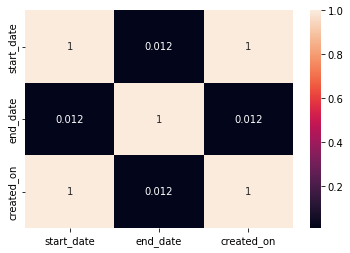

In [696]:
#print(df_entrenamiento_inicial[columnas_fecha].corr(method="pearson"))
#df_entrenamiento_inicial.start_date.corr(df_entrenamiento_inicial.end_date, method="pearson")
#df_entrenamiento_inicial[columnas_fecha].apply(lambda x: x.factorize()[0]).corr()
graficar_correlograma(df_entrenamiento_inicial[columnas_fecha].apply(
    lambda x: x.factorize()[0]), columnas_fecha)


Se observa claramente que `start_date` y `created_on` son la misma columna.

In [697]:
assert (df_entrenamiento_inicial.start_date ==
        df_entrenamiento_inicial.created_on).sum() == len(df_entrenamiento_inicial), \
    "El ds de entrenamiento tiene diferencias entre columnas start_date y created_on"


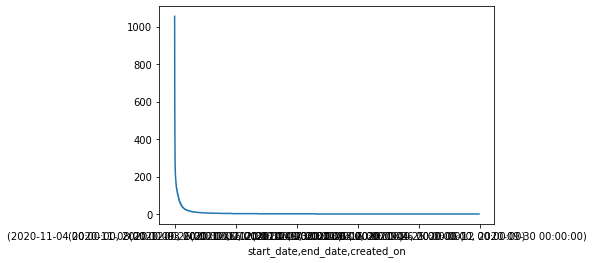

In [698]:
df_entrenamiento_inicial[columnas_fecha].value_counts().plot();
#df_entrenamiento_inicial[columnas_fecha].value_counts()[:5].plot()


Se puede observar que las combinaciones de fechas siguen un patron de "Ley de Potencias".

¿Que pasa con cada columna individual?

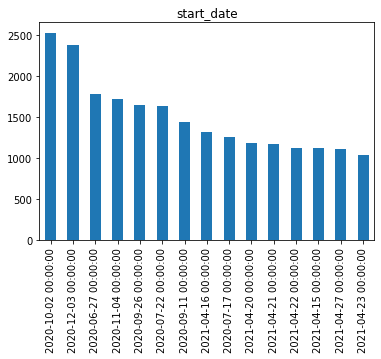

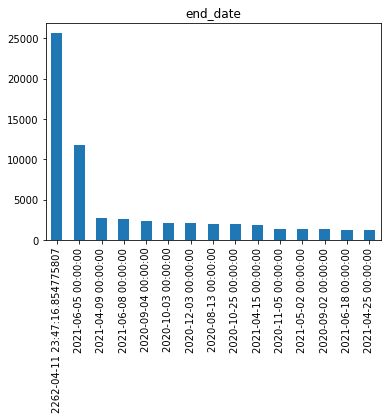

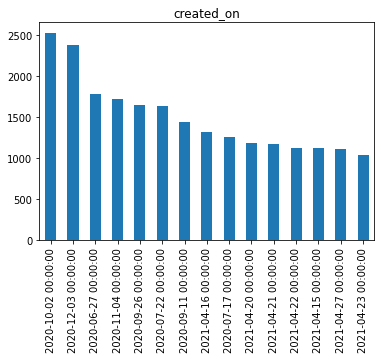

In [699]:
for columna in columnas_fecha:
    df_entrenamiento_inicial[columna].value_counts()[:15].plot(kind='bar')
    plt.title(columna)
    plt.show()


La columna `end_date` se usa bastante mal. El valor con mayor frecuencia es `9999-12-31` (reemplazado por el máximo, pero sigue siendo anomalo). El mismo aparece mas del 20 % de las veces.

### Estudio de columnas de publicación

Las columnas de publicación son aquellas que refieren a información de la propiedad publicada.

In [700]:
df_entrenamiento_inicial[columnas_publicacion].describe(include=object)

,currency,price_period,title,description,property_type,operation_type
count,144535,67507,144535,144535,144535,144535
unique,1,1,77029,111801,2,1
top,USD,Mensual,Departamento - Belgrano,Pozo en Villa Crespo. Monoambientes y Versátil...,Departamento,Venta
freq,144535,67507,1084,98,131151,144535


In [701]:
df_entrenamiento_inicial[columnas_publicacion].describe()


,price
count,1.445350e+05
mean,2.296061e+05
std,3.004743e+05
min,1.100000e+01
25%,1.000000e+05
50%,1.495000e+05
75%,2.402400e+05
max,2.140000e+07


In [702]:
columnas_publicacion_sin_precio = list(columnas_publicacion)
columnas_publicacion_sin_precio.remove('price')


<AxesSubplot:>

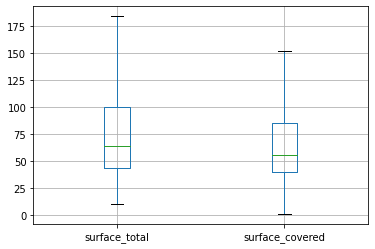

In [703]:
df_entrenamiento_inicial[['surface_total', 'surface_covered']].boxplot(
    showfliers=False)


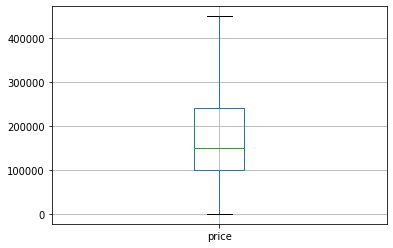

In [704]:
df_entrenamiento_inicial[['price']].boxplot(
    showfliers=False);


En cuanto a los NaNs presentes en estas columnas, se puede observar lo siguiente:

In [705]:
#print("Colname - % de nulls")
#df_entrenamiento_inicial[columnas_publicacion].isna(
#).sum() / len(df_entrenamiento_inicial)

#print("Colname - % de nulls")
prop_nans_por_columna = df_entrenamiento_inicial.isna(
).sum() / len(df_entrenamiento_inicial)
columnas_con_nans_a_descartar = list(
    prop_nans_por_columna[prop_nans_por_columna > ELIMINAR_COLS_CON_NAN_PROPORCION].index)
columnas_con_nans_a_descartar


['l4', 'l5', 'l6', 'price_period']

Se observan varios casos donde la cantidad de NaNs es mas de la mitad de las columnas

In [706]:
#df_entrenamiento_inicial.boxplot(list(df_entrenamiento_inicial.columns))
#df_entrenamiento_inicial.boxplot()


## Varianza de las columnas

se eliminan las columnas cuyos valores son identicos en todos los registros

In [707]:
columnas_con_varianza_cero = []

for column in df_entrenamiento_inicial.columns:
  if (df_entrenamiento_inicial[column] == df_entrenamiento_inicial[column][0]).all():
    columnas_con_varianza_cero.append(column)
    print(f"\nLa col {column} tiene varianza cero")
    print(df_entrenamiento_inicial[column].value_counts())
columnas_con_varianza_cero



La col ad_type tiene varianza cero
Propiedad    144535
Name: ad_type, dtype: int64

La col l1 tiene varianza cero
Argentina    144535
Name: l1, dtype: int64

La col l2 tiene varianza cero
Capital Federal    144535
Name: l2, dtype: int64

La col currency tiene varianza cero
USD    144535
Name: currency, dtype: int64

La col operation_type tiene varianza cero
Venta    144535
Name: operation_type, dtype: int64


['ad_type', 'l1', 'l2', 'currency', 'operation_type']

## Otras columnas a descartar

- Se descarta `created_on` por ser identica a `start_date`

In [708]:
columnas_a_descartar = [
    'created_on',
]

# Tratamiento de los datos

**TODO**
* ~~Determinar método para eliminar columnas con mas de un X % de NaNs.~~
* ~~Pasar cols de fechas a datetimes~~
* ~~Eliminar col created_on pues es igual a start_date~~

In [709]:
print(df_entrenamiento_inicial.shape)
df_entrenamiento_nuevas_columnas = df_entrenamiento_inicial
df_prueba = df_prueba_inicial.copy()


(144535, 26)


## Creación de nuevas columnas

### Columnas derivadas de fechas

Columnas que se crean a partir de las fechas:

- duracion_publicacion: tiempo que la publicación esta en linea, en cantidad de dias. Resta end_date menos start_date. Si end_date es mayor a fecha de hoy, se queda con fecha de hoy.

In [710]:
def crear_columna_duracion(df, columna_inicio="start_date", columna_fin="end_date"):
    hoy = pd.to_datetime(date.today())
    columna_fin = df[columna_fin].copy()
    columna_fin.replace({pd.Timestamp.max: pd.to_datetime(date.today())}, inplace=True)
    #duracion_publicacion = (columna_fin - df[columna_inicio]).dt.days
    duracion_publicacion = columna_fin - df[columna_inicio]
    return duracion_publicacion.dt.days


df_entrenamiento_nuevas_columnas["duracion_publicacion"] = crear_columna_duracion(df_entrenamiento_nuevas_columnas)
df_prueba["duracion_publicacion"] = crear_columna_duracion(df_prueba)
#df_entrenamiento_palermo["duracion_publicacion"] = crear_columna_duracion(df_entrenamiento_nuevas_columnas)
#df_prueba_palermo["duracion_publicacion"] = crear_columna_duracion(df_prueba)


### Columnas derivadas de barrios

- encoding de barrios
- desvio del m2 promedio de barrio (cubiertos y totales)

In [711]:
BARRIOS_ENCODER=False
if BARRIOS_ENCODER:
    label_encoder = LabelEncoder()
    label_encoder.fit(barrios_caba)
    df_entrenamiento_nuevas_columnas["barrios_encoded"] = label_encoder.transform(df_entrenamiento_nuevas_columnas.l3)
    df_prueba["barrios_encoded"] = label_encoder.transform(df_prueba.l3)


In [712]:
#print(df_entrenamiento_nuevas_columnas.groupby(df_entrenamiento_nuevas_columnas.l3)["surface_total"].median())
#df_entrenamiento_nuevas_columnas.surface_covered - mediana_surface_covered_por_barrio[df_entrenamiento_nuevas_columnas.l3]
#df_entrenamiento_nuevas_columnas.surface_covered - \
#    mediana_surface_covered_por_barrio[df_entrenamiento_nuevas_columnas.l3]
mediana_surface_covered_por_barrio = df_entrenamiento_nuevas_columnas.groupby(df_entrenamiento_nuevas_columnas.l3)["surface_covered"].median()
df_entrenamiento_nuevas_columnas["distancia_mediana_m2_cubiertos"] = abs(df_entrenamiento_nuevas_columnas.surface_covered - \
    df_entrenamiento_nuevas_columnas.l3.map(mediana_surface_covered_por_barrio))
df_prueba["distancia_mediana_m2_cubiertos"] = abs(df_prueba.surface_covered - \
    df_prueba.l3.map(mediana_surface_covered_por_barrio))


In [713]:
mediana_surface_total_por_barrio = df_entrenamiento_nuevas_columnas.groupby(
    df_entrenamiento_nuevas_columnas.l3)["surface_total"].median()
df_entrenamiento_nuevas_columnas["distancia_mediana_m2_totales"] = abs(df_entrenamiento_nuevas_columnas.surface_total - \
    df_entrenamiento_nuevas_columnas.l3.map(mediana_surface_total_por_barrio))
df_prueba["distancia_mediana_m2_totales"] = abs(df_prueba.surface_total - \
    df_prueba.l3.map(mediana_surface_total_por_barrio))


### Columnas derivadas de texto

* Palabras importantes presentes en titulo

In [714]:
# todo a minuscula
df_entrenamiento_nuevas_columnas['title_tokenized'] = df_entrenamiento_nuevas_columnas['title'].str.lower()
df_prueba['title_tokenized'] = df_prueba['title'].str.lower()

# tokenizacion
regexp = RegexpTokenizer('\w+')
df_entrenamiento_nuevas_columnas["title_tokenized"] = df_entrenamiento_nuevas_columnas["title_tokenized"].apply(regexp.tokenize)
df_prueba["title_tokenized"] = df_prueba["title_tokenized"].apply(regexp.tokenize)

# normalizacion por ahora no

# tratamiento de palabras vacias
stopwords = nltk.corpus.stopwords.words("spanish")
#stopwords.extend(['es', 'osea', 'sólo'])
stopwords.extend(['c'])
df_entrenamiento_nuevas_columnas['title_tokenized'] = df_entrenamiento_nuevas_columnas['title_tokenized'].apply(lambda texto: [token for token in texto if token not in stopwords])
df_prueba['title_tokenized'] = df_prueba['title_tokenized'].apply(lambda texto: [token for token in texto if token not in stopwords])


In [715]:
APLICAR_STEMMING=True

if APLICAR_STEMMING:
    stemmer = SnowballStemmer('spanish')
    df_entrenamiento_nuevas_columnas['title_tokenized'] = df_entrenamiento_nuevas_columnas['title_tokenized'].apply(lambda texto: [stemmer.stem(token) for token in texto])
    df_prueba['title_tokenized'] = df_prueba['title_tokenized'].apply(lambda texto: [stemmer.stem(token) for token in texto])


In [716]:
df_entrenamiento_nuevas_columnas['title_limpio'] = df_entrenamiento_nuevas_columnas['title_tokenized'].str.join(' ')
df_prueba['title_limpio'] = df_prueba['title_tokenized'].str.join(' ')


In [717]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(
    1, 4), min_df=0.005, max_df=0.9, strip_accents='ascii', max_features=4000)
vectorizer = vectorizer.fit(
    df_entrenamiento_nuevas_columnas['title_limpio'])
vectorized_data_training = vectorizer.transform(df_entrenamiento_nuevas_columnas['title_limpio'])
vectorized_data_testing = vectorizer.transform(df_prueba['title_limpio'])
count_df_training = pd.DataFrame(vectorized_data_training.toarray(), columns=vectorizer.get_feature_names_out())
count_df_testing = pd.DataFrame(vectorized_data_testing.toarray(), columns=vectorizer.get_feature_names_out())


In [718]:
#count_df_training.sum().to_csv('2_temp_output_borrar.csv')
#count_df_testing[count_df_testing.sum() > 0]#.sum().to_csv('3_temp_output_borrar.csv')
#count_df_testing#.sum().to_csv('3_temp_output_borrar.csv')


In [719]:
AGREGAR_COLUMNAS_TEXTUALES=False
if AGREGAR_COLUMNAS_TEXTUALES:
    columnas_terminos_importantes=[
        "monoambiente", "torre", "tres", "baulera",
        "duplex", "parrilla", "pb", "cochera", "frente", "lavadero", "rio",
        "balcon", "patio", "terraza", "libertador", "depto", "piso",
        "av", "ph", "banos", "dormitorios",
    ]
    df_entrenamiento_nuevas_columnas[columnas_terminos_importantes] = count_df_training[columnas_terminos_importantes]
    df_prueba[columnas_terminos_importantes] = count_df_testing[columnas_terminos_importantes]


In [720]:
df_entrenamiento_nuevas_columnas["cantidad_palabras_importantes_titulo"] = count_df_training.sum(axis=1) / len(count_df_training.columns)
df_entrenamiento_nuevas_columnas["cantidad_palabras_importantes_titulo"].fillna(0, inplace=True) # Para los títulos que no tienen términos relevantes
df_entrenamiento_nuevas_columnas["cantidad_palabras_importantes_titulo"]


0         0.013841
1         0.027682
2         0.013841
3         0.024221
4         0.006920
            ...   
145183    0.000000
145184    0.000000
145185    0.000000
145186    0.000000
145187    0.000000
Name: cantidad_palabras_importantes_titulo, Length: 144535, dtype: float64

In [721]:
df_prueba["cantidad_palabras_importantes_titulo"] = count_df_testing.sum(axis=1) / len(count_df_testing.columns)
df_prueba["cantidad_palabras_importantes_titulo"].fillna(0, inplace=True) # Para los títulos que no tienen términos relevantes
df_prueba["cantidad_palabras_importantes_titulo"]

0       0.027682
1       0.044983
2       0.031142
3       0.027682
4       0.031142
          ...   
1082    0.034602
1083    0.031142
1084    0.031142
1085    0.024221
1086    0.038062
Name: cantidad_palabras_importantes_titulo, Length: 1087, dtype: float64

## Selección de columnas finales


In [722]:
columnas_finales = set(df_entrenamiento_nuevas_columnas.select_dtypes(include=np.number).columns) - \
    set(columnas_con_nans_a_descartar) - \
    set(columnas_con_varianza_cero) - \
    set(columnas_a_descartar)
columnas_finales.add('l3') # para el tratamiento que viene despues
columnas_finales = list(columnas_finales)
columnas_finales


['duracion_publicacion',
 'lon',
 'rooms',
 'l3',
 'cantidad_palabras_importantes_titulo',
 'bathrooms',
 'distancia_mediana_m2_cubiertos',
 'price',
 'surface_covered',
 'bedrooms',
 'distancia_mediana_m2_totales',
 'lat',
 'surface_total']

In [723]:
df_entrenamiento = df_entrenamiento_nuevas_columnas[columnas_finales]
df_prueba.index = df_prueba.id
df_prueba = df_prueba[columnas_finales]


## Separación en datasets por barrio

previo a cálculo de outliers, imputaciones, etc...

In [724]:
# Generamos sub-datasets
def generar_subdataset(df, column, filter_value):
    if not type(filter_value) == list:
        filter_value = [filter_value]
    filtered_dataset = df[df[column].isin(filter_value)].copy()
    # una vez que se filtra por el valor en column, no tiene sentido mantenerla
    #   porque tendra un unico valor.
    filtered_dataset = filtered_dataset[filtered_dataset.columns.drop(column)]
    if filtered_dataset.shape[0] > 0:
        # En este caso, algo filtro correctamente
        return filtered_dataset
    else:
        # Algo fallo, devolvió algo vacio
        return None

datasets = {
    "Palermo": {
        "train": None,
        "test": None,
    },
    "Belgrano": {
        "train": None,
        "test": None,
    },
    "Recoleta": {
        "train": None,
        "test": None,
    },
    "Caballito": {
        "train": None,
        "test": None,
    },
    "Villa Crespo": {
        "train": None,
        "test": None,
    },
    "Almagro": {
        "train": None,
        "test": None,
    },
    "Villa Urquiza": {
        "train": None,
        "test": None,
    },
    "Puerto Madero": {
        "train": None,
        "test": None,
    },
    "Resto": {
        "train": None,
        "test": None,
    },
}

for barrio, dfs in datasets.items():
    if barrio == "Resto":
        barrios_principales = list(datasets.keys())
        barrios_principales.remove("Resto")
        barrios_secundarios = df_entrenamiento_nuevas_columnas.l3.value_counts().index.drop(barrios_principales)
        barrio = list(barrios_secundarios)
        
    dfs['train'] = generar_subdataset(df_entrenamiento, "l3", barrio)
    dfs['test'] = generar_subdataset(df_prueba, "l3", barrio)

    #df_entrenamiento_nuevas_columnas = df_entrenamiento_palermo
    #df_prueba = df_prueba_palermo

#df_entrenamiento_nuevas_columnas[df_entrenamiento_nuevas_columnas.l3.isin( ['Palermo'])]


## Outliers

Detectar outliers en base al rango intercuartilico


In [725]:
# Outliers analisis
#df_entrenamiento_inicial[(np.abs(stats.zscore(df_entrenamiento_inicial)) < 3).all(axis=1)]
#np.abs(stats.zscore(df_entrenamiento_inicial)) > 3
def get_outliers(df, lt, umbral=1.5):
  Q1 = df[lt].quantile(0.25)
  Q3 = df[lt].quantile(0.75)
  IQR = Q3 - Q1
  corte_inferior = Q1 - umbral * IQR
  corte_superior = Q3 + umbral * IQR

  # armo una lista de indices con outliers
  lista = df.index[(df[lt] < corte_inferior) | (df[lt] > corte_superior)]

  return lista

DETECTAR_OUTLIERS = True
MOSTRAR_GRAFICOS_OUTLIERS = False
MOSTRAR_ESTADISTICAS_OUTLIERS = False
PROCESAR_OUTLIERS = True
if DETECTAR_OUTLIERS:
  outliers_barrio = {}
  total_outliers = 0
  total = 0
  for barrio, dfs in datasets.items():
    dfs['train'].drop(['outlier'], axis=1, errors='ignore', inplace=True) # permite ejecutar varias veces este codigo
    outliers_barrio[barrio] = {}
    columnas = dfs['train'].columns.drop('price')
    for columna in columnas:  # no busca outliers en precio
      outliers_barrio[barrio][columna] = get_outliers(dfs['train'], columna)

      # un outlier es un registro que tiene al menos uno de sus valores, outliers
      # si el criterio es eliminarlos, alcanza con una columna para eliminar el registro
      dfs['train']['outlier'] = dfs['train'].index.isin(outliers_barrio[barrio][columna])
      
      # podemos determinar el impacto de los outliers en la distribucion de cada columna
      # via graficar en base al filtro armado
      if MOSTRAR_GRAFICOS_OUTLIERS:
        sns.boxplot(x=dfs['train'][columna]).set_title(f"{barrio} - {columna} con outliers")
        plt.show()
        sns.boxplot(x=dfs['train'][columna][~dfs['train']["outlier"]]).set_title(f"{barrio} - {columna} sin outliers")
        plt.show()
      
      if MOSTRAR_ESTADISTICAS_OUTLIERS and DEBUG:
        print(f"shape con outliers {barrio} - {columna}: {dfs['train'][columna].shape}")
        print(f"shape sin outliers {barrio} - {columna}: {dfs['train'][columna][~dfs['train']['outlier']].shape}")
    total_outliers += dfs['train'][dfs['train']['outlier']].shape[0]
    total += dfs['train'].shape[0]
    if MOSTRAR_ESTADISTICAS_OUTLIERS:
      #print(f"{barrio}")
      #print(dfs['train'][dfs['train']['outlier']].shape)
      print(f"prop de outliers para {barrio}: {dfs['train'][dfs['train']['outlier']].shape[0]*100/dfs['train'].shape[0]}")
  
  if MOSTRAR_ESTADISTICAS_OUTLIERS:
    print(f"Total Outliers: {total_outliers}")
    print(f"Total Outliers: {total}")


  #lista_outliers = {}
  #conjunto_outliers = set([])

  ## la columna precio no fue incluida
  #for col in ['rooms', 'bedrooms', 'bathrooms', 'surface_covered', 'surface_total', 'lon', 'lat']:
  #  lista_outliers[col] = outliers(df_entrenamiento, col)
  #  conjunto_outliers.update(lista_outliers[col])

  #print(len(df_entrenamiento))
  #print(len(lista_outliers))
  #print(len(conjunto_outliers))

if PROCESAR_OUTLIERS:
  dfs['train'] = dfs['train'][~dfs['train']["outlier"]]

for barrio, dfs in datasets.items():
  dfs['train'].drop(['outlier'], axis=1, errors='ignore', inplace=True)


## Imputaciones

Varias imputaciones serán realizadas:

- Imputación manual de datos incorrectos
- Simple Imputer para NaNs

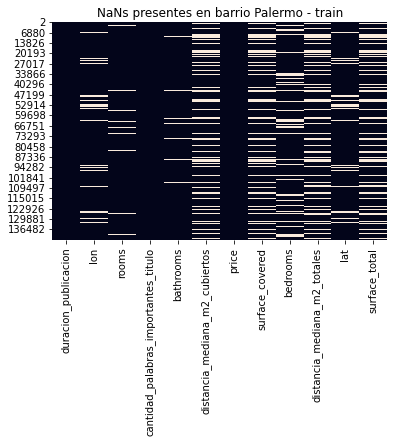

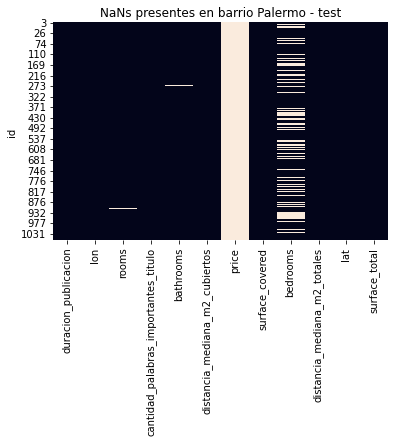

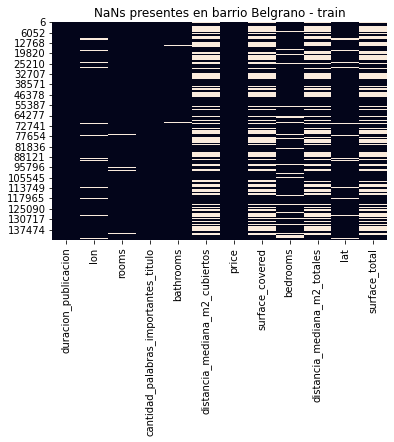

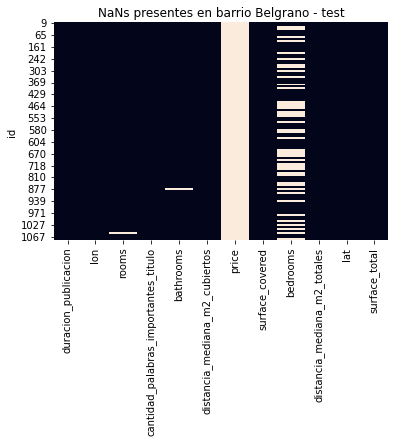

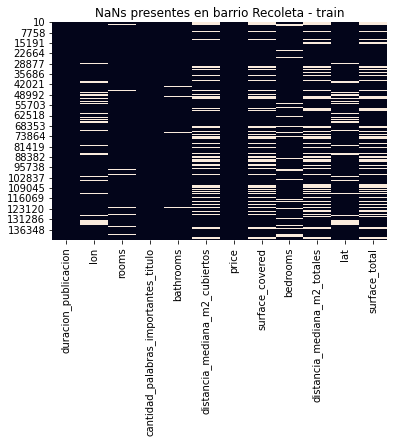

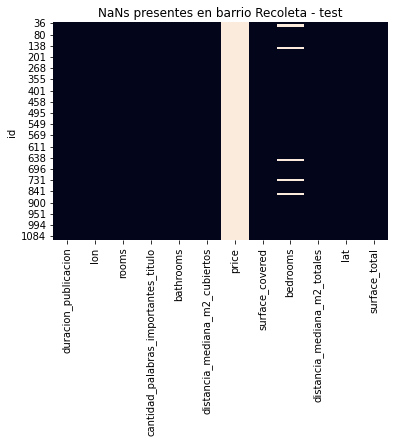

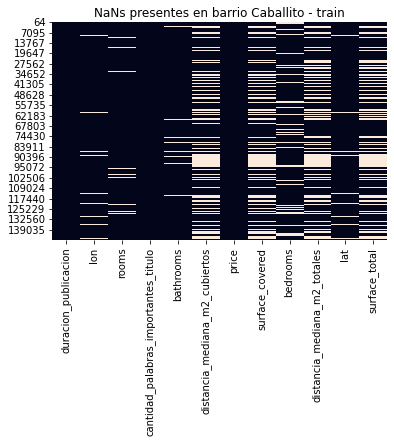

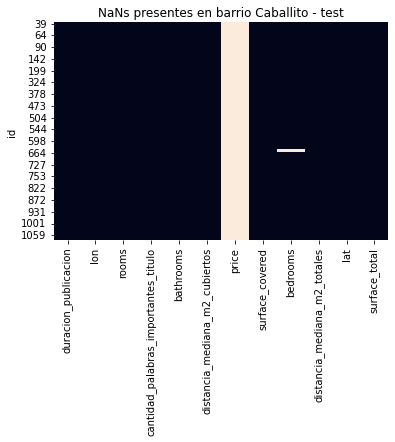

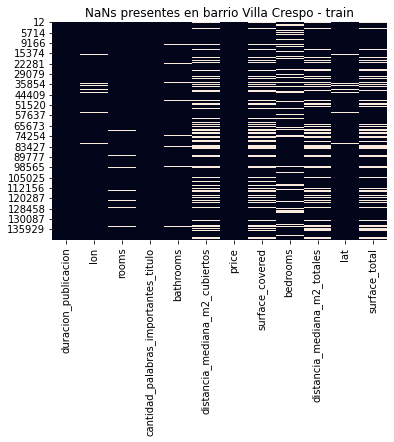

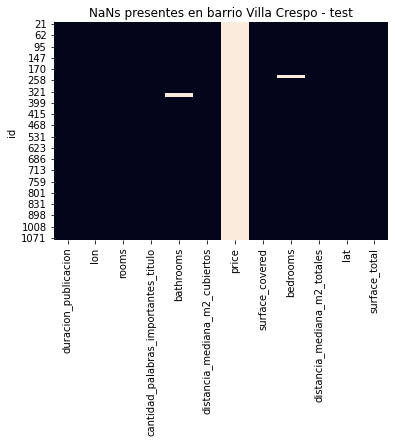

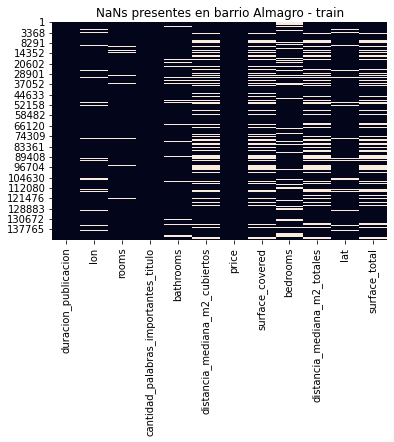

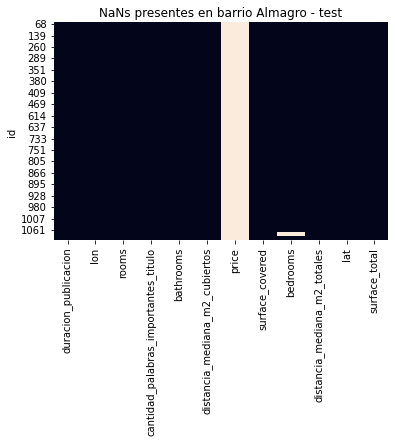

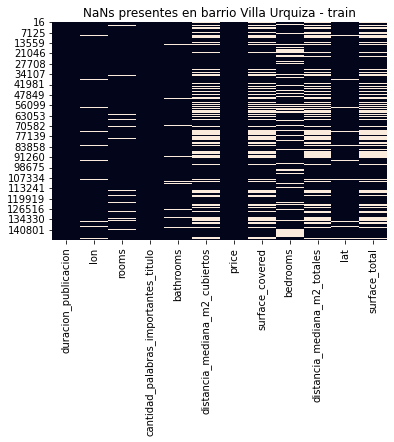

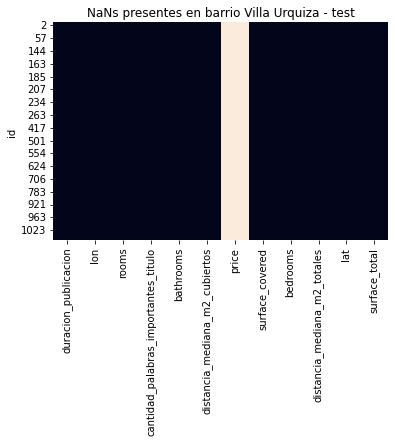

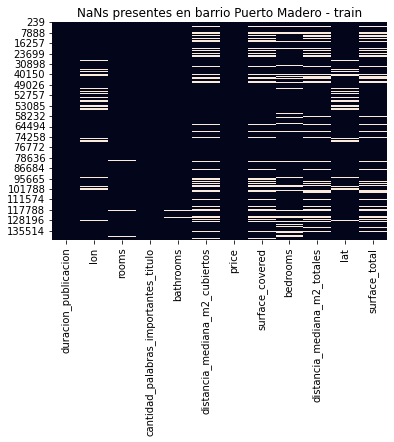

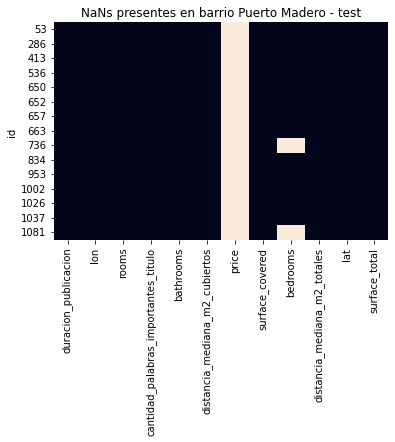

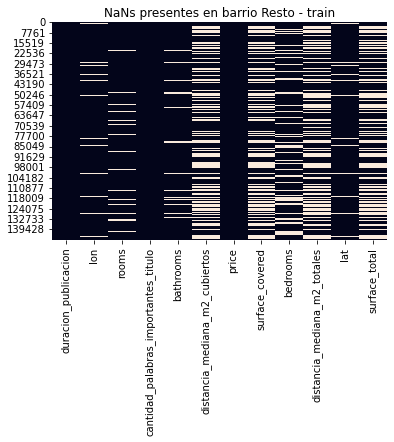

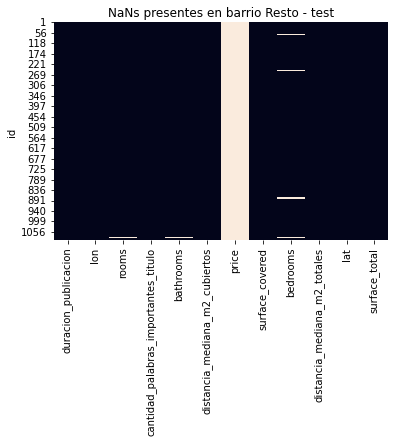

In [726]:
for barrio, dfs in datasets.items():
    for tipo_df, df in dfs.items():
        title = f"NaNs presentes en barrio {barrio} - {tipo_df}"
        plot_nans(df, title=title)


In [727]:
IMPUTAR_SIMPLE = True
SIMPLE_IMPUTE_METHOD = 'median'
#SIMPLE_IMPUTE_METHOD = 'mean'


def imputacion_simple(df, columnas, df_train=None, strategy='median'):
    if df_train is None:
        # escenario de imputacion del propio df de entrenamiento
        df_train = df
    df_train_copy = df_train[columnas].copy()

    imp = SimpleImputer(strategy=strategy)
    # strategy == mean, median, most_frequent, constant
    imputador = imp.fit(df_train_copy)
    df_imputado = imputador.transform(df)
    return pd.DataFrame(df_imputado, columns=columnas, index=df.index)


def imputacion_knn(df, columnas, df_train=None):
    if df_train is None:
        # escenario de imputacion del propio df de entrenamiento
        df_train = df
    df_train_imputacion = df_train[columnas].copy()
    normalizo_df_train = df_train_imputacion.values
    escala_min_max = preprocessing.MinMaxScaler()
    escala_min_max.fit(normalizo_df_train)
    norm_escala_train = escala_min_max.transform(normalizo_df_train)
    df_norm_train = pd.DataFrame(norm_escala_train, columns=columnas)

    normalizo_df = df[columnas].copy().values
    norm_escala = escala_min_max.transform(normalizo_df)
    df_norm = pd.DataFrame(norm_escala, columns=columnas)

    # Plotea las distribuciones de KNN
    #fig, ax = plt.subplots()
    #sns.kdeplot(df_imputacion.surface_total, label="Original Distribution", ax=ax)
    #df_knn_imputed = df[columnas].copy(deep=True)
    #for n in range(2, 5):
    #    for peso in ["distance", "uniform"]:
    #        imp = KNNImputer(n_neighbors=n, weights=peso)
    #        df_knn_imputed.loc[:, :] = imp.fit_transform(df_imputacion)
    #        sns.kdeplot(
    #            df_knn_imputed.surface_total, label=f"Imputed Dist with k={n}; pesos={peso}", ax=ax)
    #ax.set_xlim(-1000, 1000)
    #plt.legend()

    imp = KNNImputer(n_neighbors=3, weights="distance")
    imputador = imp.fit(df_norm_train)
    #imputador = imputador.fit(df_norm_train)
    df_imputado = imputador.transform(df_norm)
    return pd.DataFrame(df_imputado, columns=columnas, index=df.index)


In [728]:
from sklearn import preprocessing
from sklearn.impute import KNNImputer

IMPUTAR_CON_KNN = False
IMPUTAR_SIMPLE = True
#SIMPLE_IMPUTE_METHOD = 'median'
#SIMPLE_IMPUTE_METHOD = 'mean'
SIMPLE_IMPUTE_METHOD = 'most_frequent'



def imputar_knn_por_barrio(datasets):
    colgroup_no_imputable = ['price', 'duracion_publicacion', 'cantidad_palabras_importantes_titulo']
    colgroups = {
        "surfaces": ['surface_total', 'surface_covered',
                     'bathrooms', 'distancia_mediana_m2_cubiertos',
                     'distancia_mediana_m2_totales'],
        "ubicaciones": ['lat', 'lon'],
        "habitaciones": ['bathrooms', 'rooms', 'bedrooms'],
    }

    dfs_intermedios = {
        "train": {
            "surfaces": None,
            "ubicaciones": None,
            "habitaciones": None,
        },
        "test": {
            "surfaces": None,
            "ubicaciones": None,
            "habitaciones": None,
        },
    }

    for barrio, dfs in datasets.items(): # itera por los dfs de cada barrio
        for tipo, df in dfs.items(): # itera por train o test
            for nombre, colgroup in colgroups.items(): # itera por los grupos de columnas a imputar
                # si bien el siguiente if es medio innecesario, resalta el hecho de que
                # para test se imputa teniendo en cuenta entrenamiento.
                if tipo == "test":
                    dfs_intermedios[tipo][nombre] = imputacion_knn(df, colgroup, dfs["train"])
                else:
                    dfs_intermedios[tipo][nombre] = imputacion_knn(df, colgroup)
            
            dfs_intermedios[tipo]["imputados"] = pd.concat([df[colgroup_no_imputable],
                                                            dfs_intermedios[tipo]["surfaces"],
                                                            dfs_intermedios[tipo]["ubicaciones"],
                                                            dfs_intermedios[tipo]["habitaciones"][dfs_intermedios[tipo]["habitaciones"].columns.drop('bathrooms')]], axis=1)
            # controles
            #assert dfs_intermedios[tipo]["imputados"].shape == df.shape, f"El shape en {barrio} -> {tipo} no coinciden: imputado: {dfs_intermedios[tipo]['imputados'].shape}, original: {df.shape}"
            try:
                if not dfs_intermedios[tipo]["imputados"].shape == df.shape:
                    raise Exception(f"El shape en {barrio} -> {tipo} no coinciden: imputado: {dfs_intermedios[tipo]['imputados'].shape}, original: {df.shape}")
                dfs[tipo] = dfs_intermedios[tipo]["imputados"] # Aca piso los originales y me quedo con los imputados
            except Exception as e:
                print(str(e))
                print("columnas df imputado:", dfs_intermedios[tipo]["imputados"].columns)
                print("columnas df original:", df.columns)


def imputar_simple_por_barrio(datasets, strategy='median'):
    dfs_intermedios = {
        "train": None,
        "test": None,
    }
    for barrio, dfs in datasets.items():  # itera por los dfs de cada barrio
        for tipo, df in dfs.items():  # itera por train o test
            # si bien el siguiente if es medio innecesario, resalta el hecho de que
            # para test se imputa teniendo en cuenta entrenamiento.
            columnas_imputables = df.select_dtypes(include=['float64', 'int64', 'uint8']).columns
            if tipo == "test":
                dfs[tipo] = imputacion_simple(df, columnas_imputables, df_train=dfs["train"], strategy=strategy)
            else:
                dfs[tipo] = imputacion_simple(df, columnas_imputables, strategy=strategy)

if IMPUTAR_CON_KNN:
    imputar_knn_por_barrio(datasets)
elif IMPUTAR_SIMPLE:
    imputar_simple_por_barrio(datasets, strategy=SIMPLE_IMPUTE_METHOD)
else:
    imputar_simple_por_barrio(datasets, strategy=SIMPLE_IMPUTE_METHOD)


    #colgroup_uno = ['surface_total', 'surface_covered',
    #                'bathrooms', 'distancia_mediana_m2_cubiertos', 
    #                'distancia_mediana_m2_totales']
    #colgroup_dos = ['lat', 'lon']
    #colgroup_tres = ['bathrooms', 'rooms', 'bedrooms']

    ##df_imputado_train_surfaces = imputacion_knn(df_entrenamiento, colgroup_uno)
    ##df_entrenamiento_imputado_surfaces = df_imputado_train_surfaces[df_imputado_train_surfaces.columns]
    #df_entrenamiento_imputado_surfaces = imputacion_knn(df_entrenamiento, colgroup_uno)
    #df_prueba_imputado_surfaces = imputacion_knn(df_prueba, colgroup_uno, df_entrenamiento)

    ##df_imputado_train_ubicaciones = imputacion_knn(df_entrenamiento, colgroup_dos)
    ##df_entrenamiento_imputado_ubicaciones = df_imputado_train_ubicaciones[df_imputado_train_ubicaciones.columns]
    #df_entrenamiento_imputado_ubicaciones = imputacion_knn(df_entrenamiento, colgroup_dos)
    #df_prueba_imputado_ubicaciones = imputacion_knn(df_prueba, colgroup_dos, df_entrenamiento)

    ##df_imputado_train_habitaciones = imputacion_knn(df_entrenamiento, colgroup_tres)
    ##df_entrenamiento_imputado_habitaciones = df_imputado_train_habitaciones[df_imputado_train_habitaciones.columns]
    #df_entrenamiento_imputado_habitaciones = imputacion_knn(df_entrenamiento, colgroup_tres)
    #df_prueba_imputado_habitaciones = imputacion_knn(df_prueba, colgroup_tres, df_entrenamiento)


Volvemos a controlar los NaNs con el heatmap

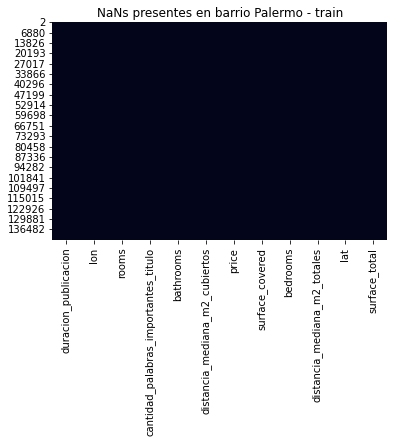

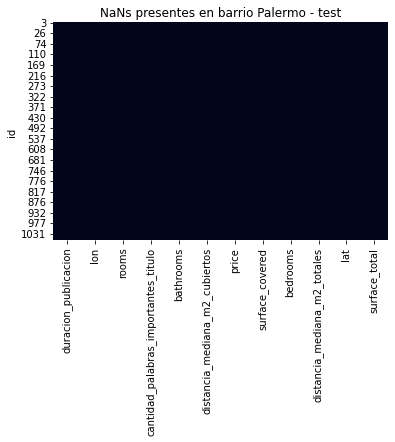

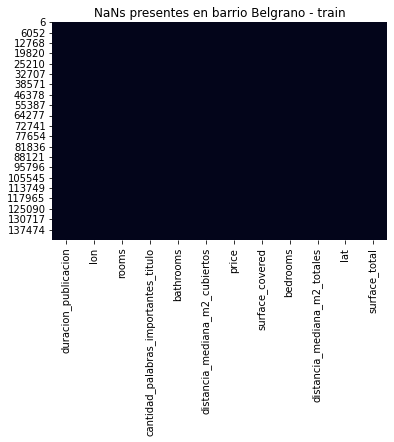

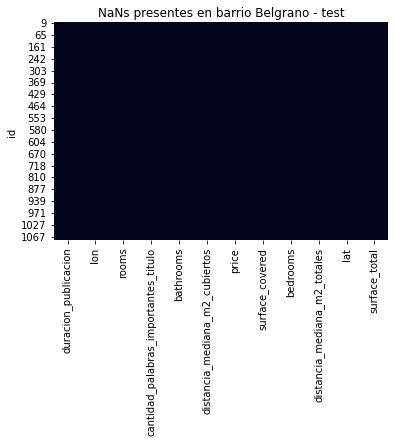

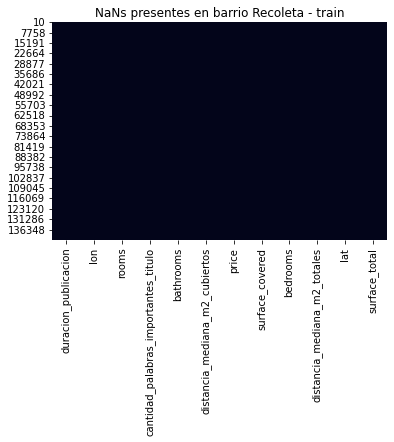

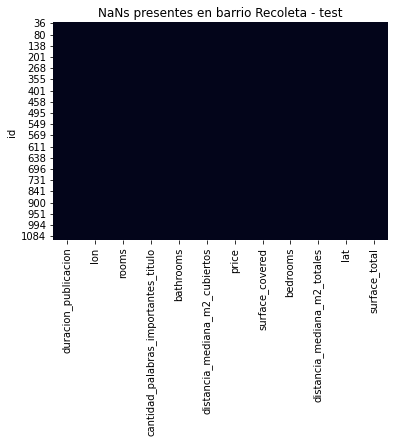

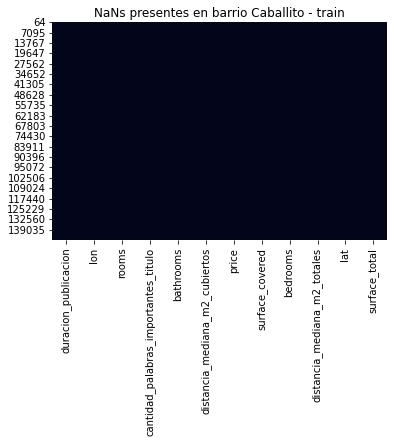

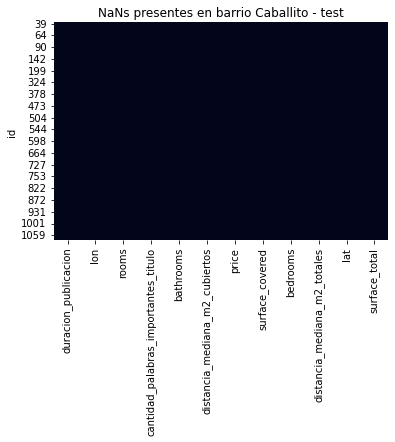

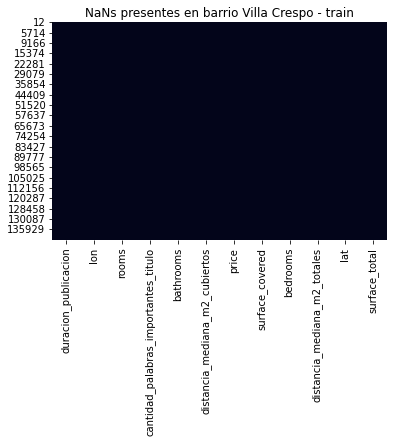

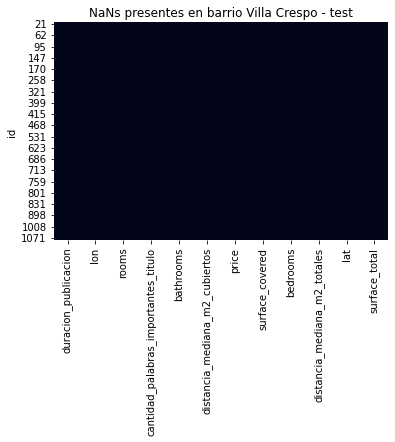

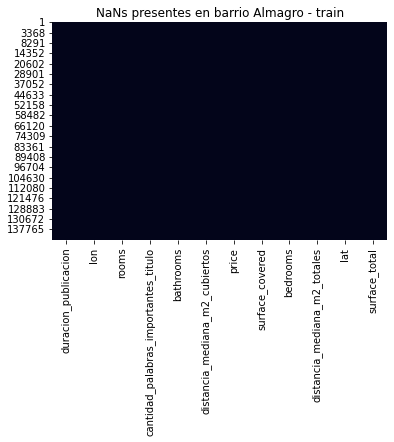

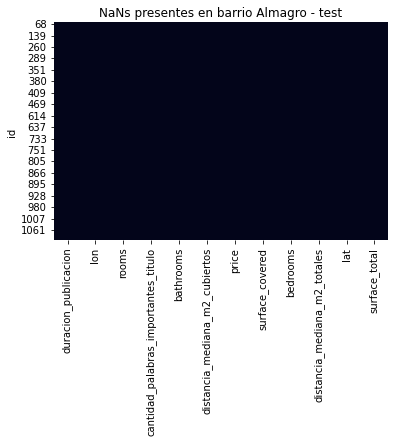

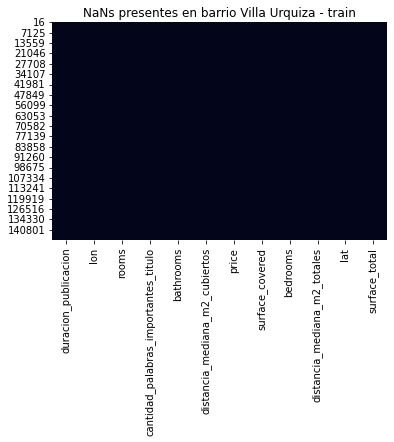

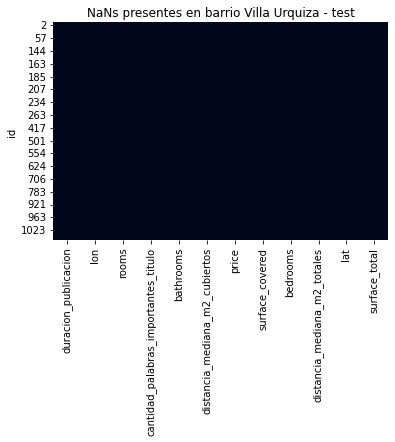

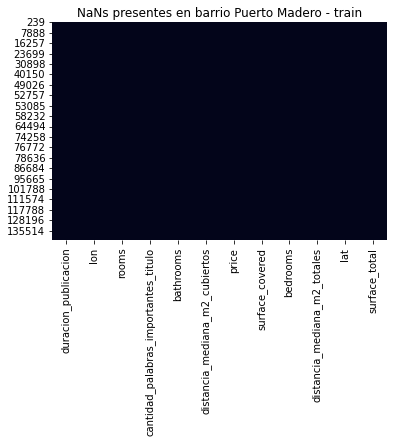

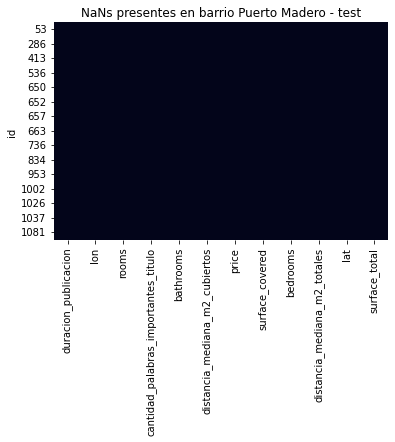

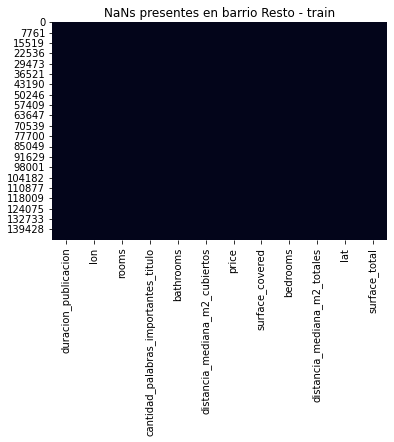

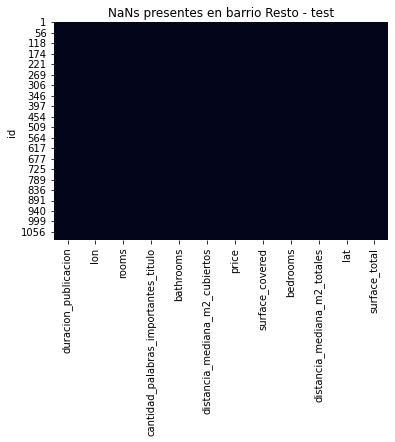

In [729]:
for barrio, dfs in datasets.items():
    for tipo_df, df in dfs.items():
        title = f"NaNs presentes en barrio {barrio} - {tipo_df}"
        plot_nans(df, title=title)


In [730]:
#df_entrenamiento_imputado_surfaces.compare(
#    df_entrenamiento[df_entrenamiento_imputado_surfaces.columns])


In [731]:
#df_imputado_entrenamiento = pd.concat([df_entrenamiento[['price', 'duracion_publicacion', 'cantidad_palabras_importantes_titulo']],
#                                       df_entrenamiento_imputado_surfaces,
#                                       df_entrenamiento_imputado_ubicaciones,
#                                       df_entrenamiento_imputado_habitaciones[df_entrenamiento_imputado_habitaciones.columns.drop('bathrooms')]], axis=1)
#
#df_imputado_prueba = pd.concat([df_prueba[['price', 'duracion_publicacion', 'cantidad_palabras_importantes_titulo']],
#                                df_prueba_imputado_surfaces,
#                                df_prueba_imputado_ubicaciones,
#                                df_prueba_imputado_habitaciones[df_prueba_imputado_habitaciones.columns.drop('bathrooms')]], axis=1)


In [732]:
# Chequeos extras para controlar que todo quedo bien

#print(df_entrenamiento.columns)
#print(df_entrenamiento.shape)
#print(df_imputado_entrenamiento.columns)
#print(df_imputado_entrenamiento.shape)
#
#print(df_prueba.columns)
#print(df_prueba.shape)
#print(df_imputado_prueba.columns)
#print(df_imputado_prueba.shape)


In [733]:
DROPNA = False
if DROPNA:
    df_imputado = df_imputado.dropna()


In [734]:
#sns.heatmap(df_imputado_entrenamiento.isnull(), cbar=False);
#plt.show()
#sns.heatmap(df_imputado_prueba.isnull(), cbar=False)
#plt.show()


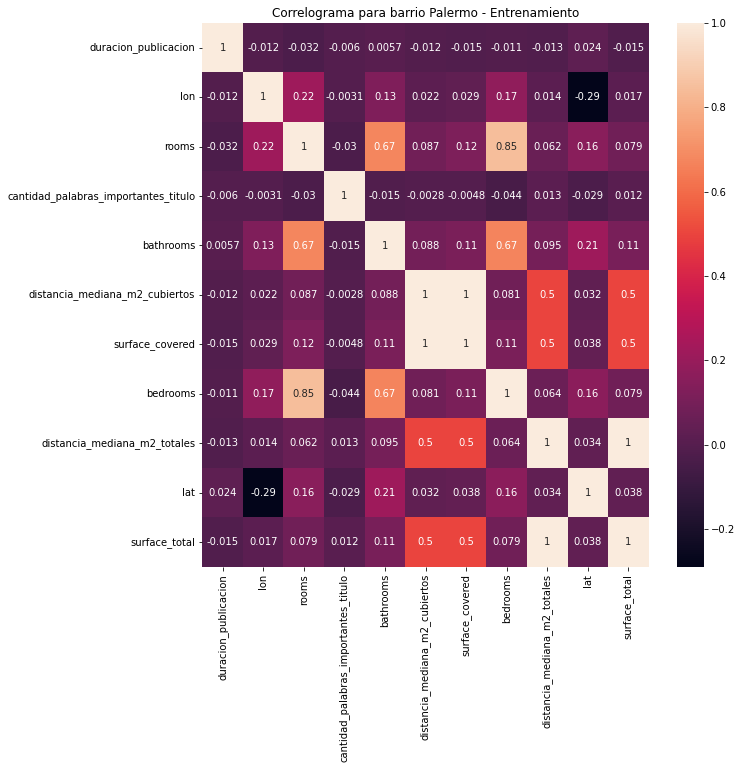

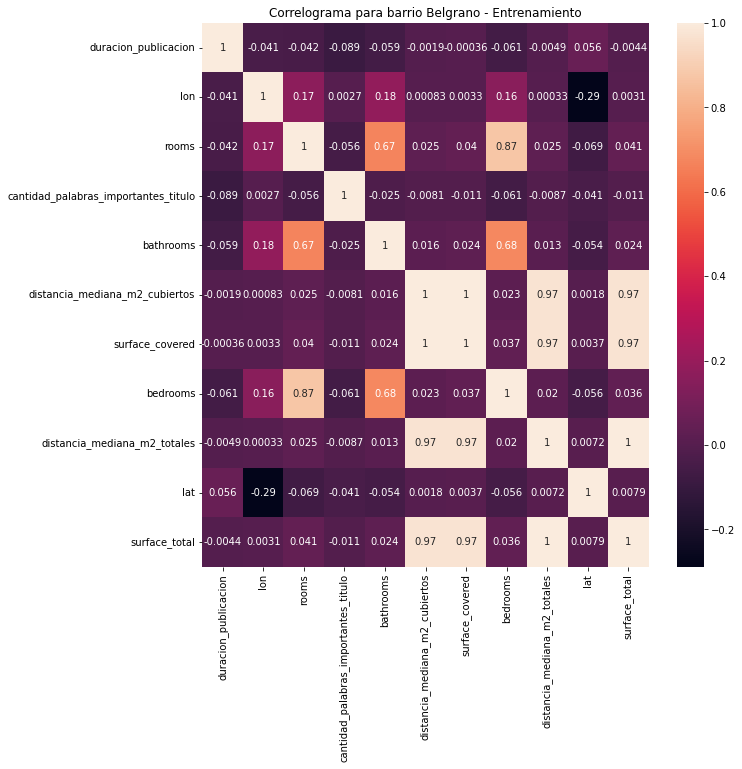

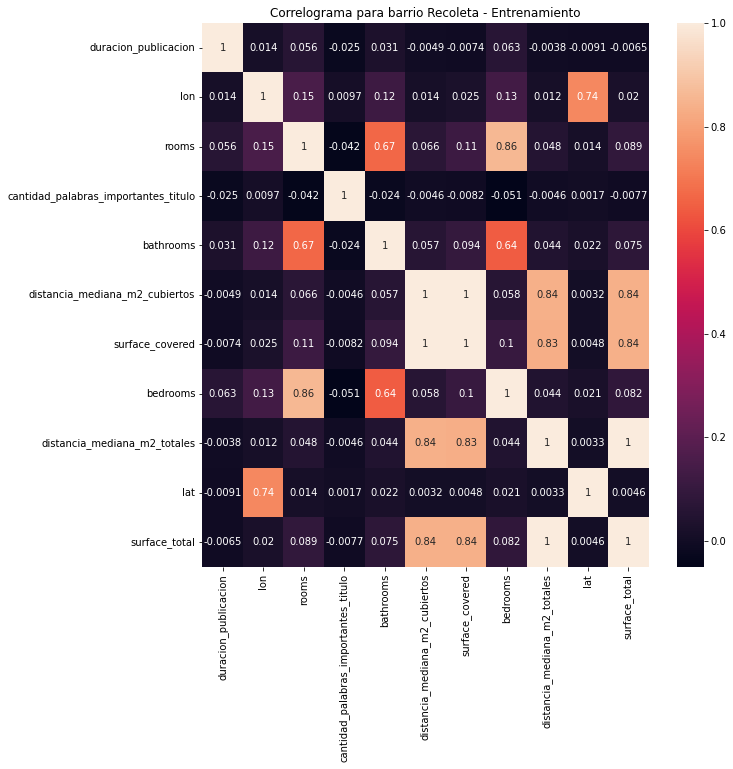

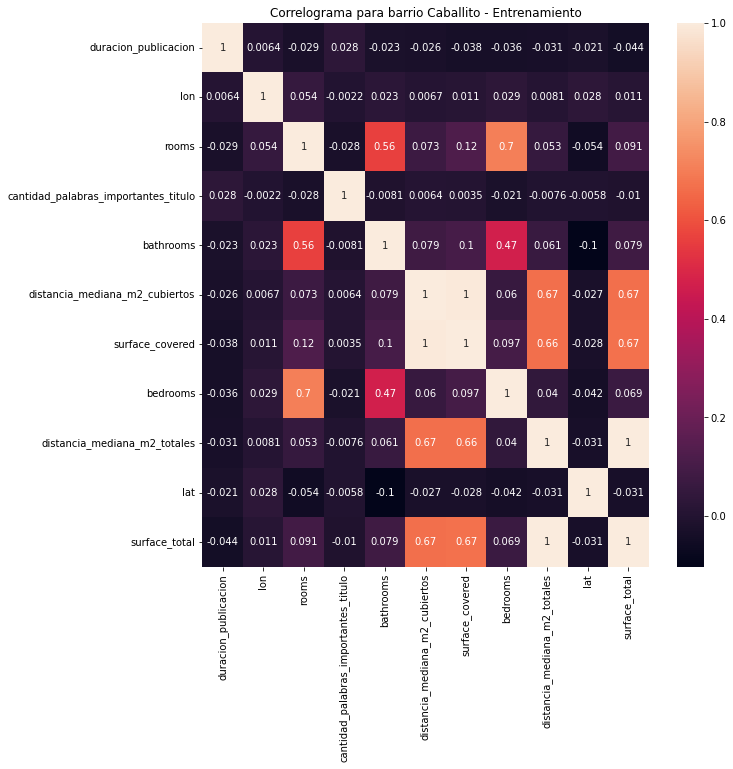

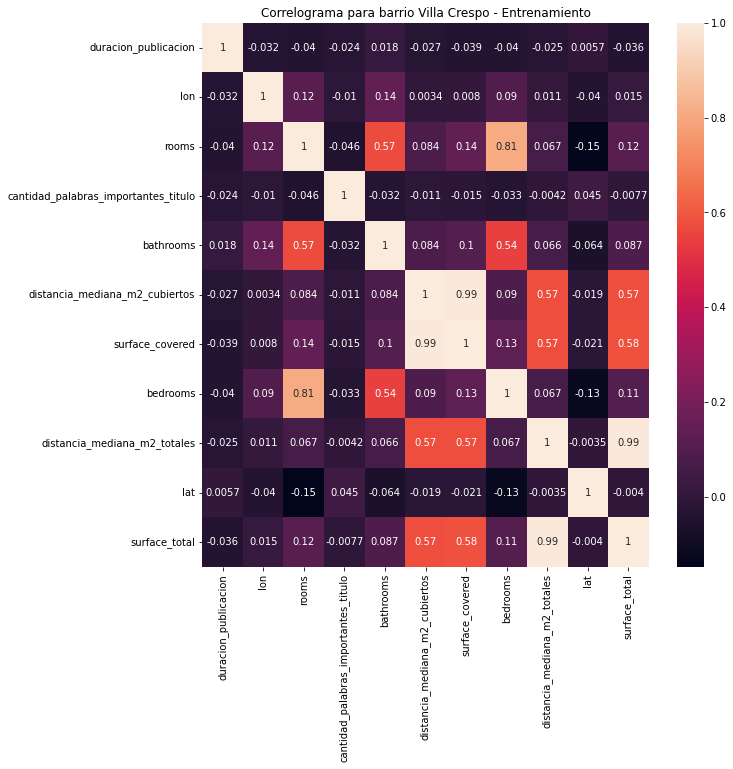

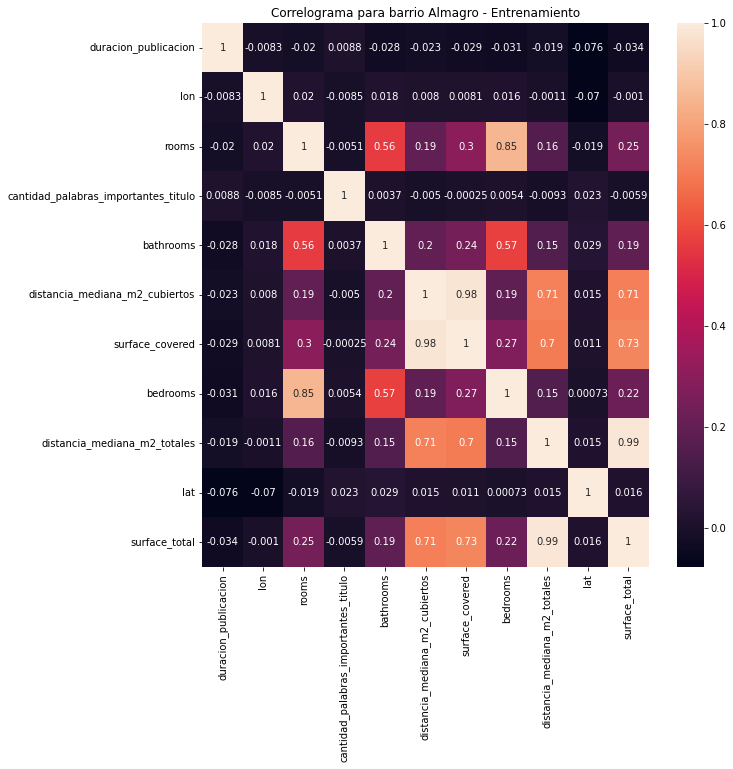

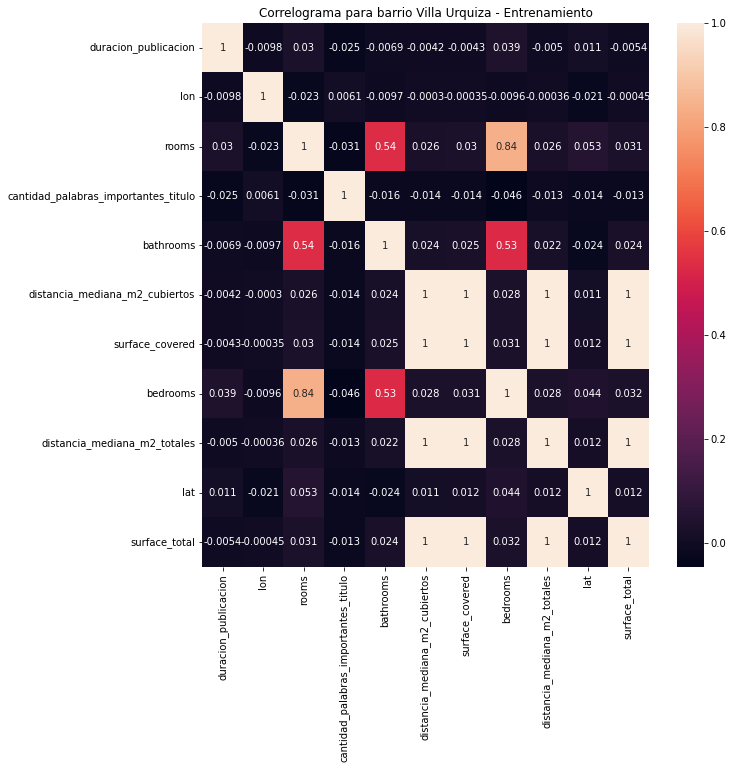

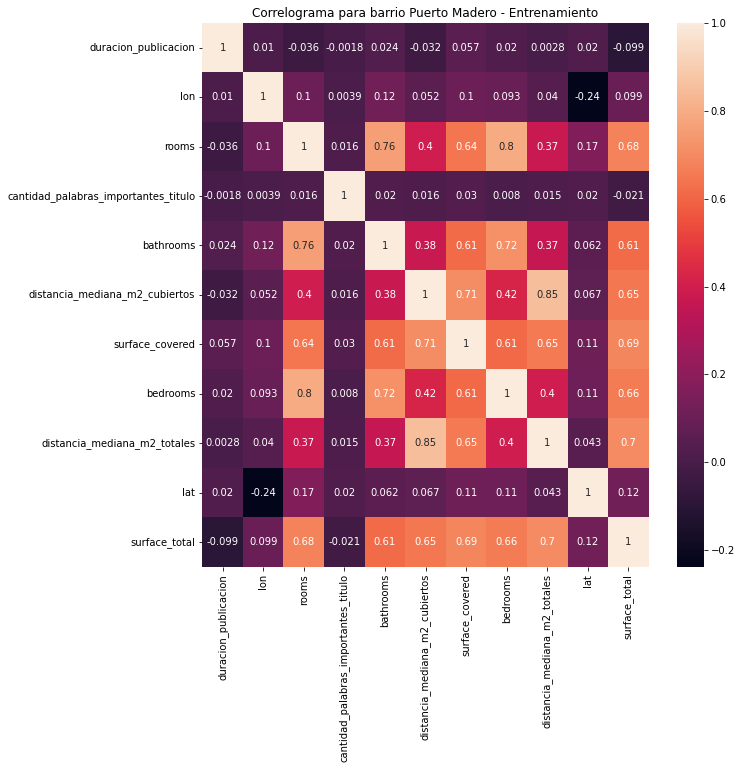

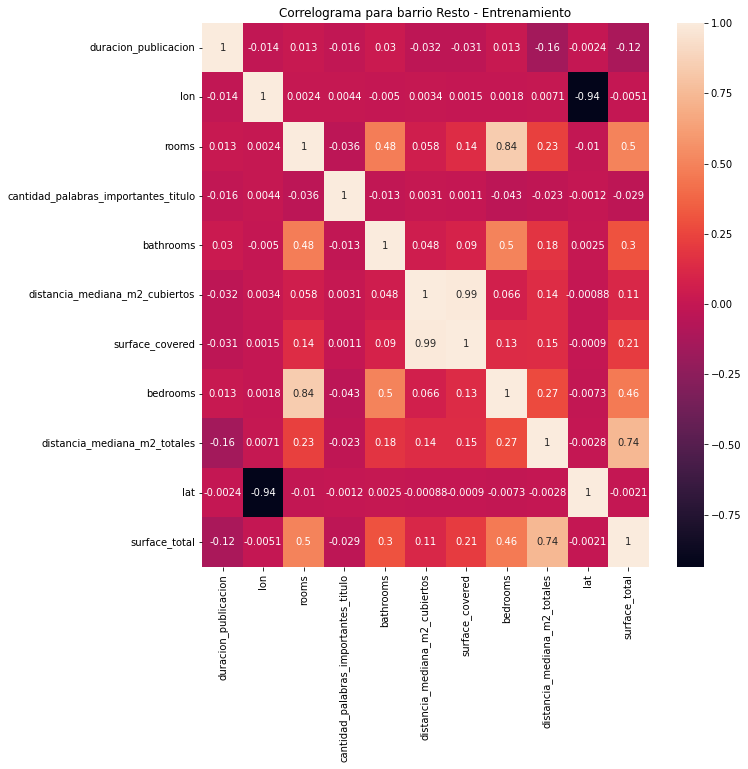

In [735]:
#fig, ax = plt.subplots(figsize=(10, 10))
#sns.heatmap(df_imputado_entrenamiento[df_imputado_entrenamiento.columns.drop(
#    'price')].corr(), annot=True, ax=ax);

for barrio, dfs in datasets.items():
    title = f"Correlograma para barrio {barrio} - Entrenamiento"
    plot_correlogramas(dfs["train"], title=title)


In [736]:
# reemplazar esto por un algoritmo
#columnas_con_alta_correlacion = ['bedrooms', 'lat', 'surface_total']
#df_imputado = df_imputado[df_imputado.columns.drop(
#    columnas_con_alta_correlacion)]


In [737]:
#df_imputado_prueba.isna().sum()


## Estandarización y Normalización de Datos númericos


In [738]:
#df_imputado = df_imputado_entrenamiento
#df_prueba = df_imputado_prueba

In [739]:
NORMALIZAR=False

if NORMALIZAR:
    dfe_estandarizado = df_imputado.select_dtypes(
        include=['float64', 'int64', 'uint8'])

    # ESTO NO SE SI ANDA
    #df_entrenamiento_inicial.lat.hist(bins=50)

    features = dfe_estandarizado.columns.drop('price')

    # estandarización min-max
    dfe_estandarizado[features] = (dfe_estandarizado[features] -
                        dfe_estandarizado[features].min()) / (dfe_estandarizado[features].max() - dfe_estandarizado[features].min())

    dfe_transformado = pd.DataFrame([])
    dfe_transformado[features] = np.sqrt(dfe_estandarizado[features])
    dfe_transformado["price"] = dfe_estandarizado["price"]

    #dfe_estandarizado = dfe_estandarizado
    #dfe_transformado.lat.hist(bins=50);
else:
    #dfe_transformado = dfe_estandarizado
    pass


In [740]:
#df_entrenamiento_inicial.lat.describe()
#dfe_transformado.head()


## Eliminación de columnas con baja varianza


In [741]:
#df2 = dfe_transformado.select_dtypes(
#    include=['float64', 'int64', 'uint8'])
#
#varianzas_cols = {}
#for c in df2.columns:
#    varianzas_cols[c] = df2[c].var()
#
#varianzas_ordenadas = dict(sorted(varianzas_cols.items(
#), key=lambda item: item[1]), sort_keys=True, indent=4)
#columnas_con_baja_varianza = []
#for col, varianza in varianzas_ordenadas.items():
#    print(col, varianza)
#    if varianza < 1:
#        columnas_con_baja_varianza.append(col)
#
#print(columnas_con_baja_varianza)


In [742]:
columnas_con_baja_varianza = []


# Modelización

A continuación se define la selección de columnas a ser utilizadas

In [743]:
#columnas_a_modelar = set(df_entrenamiento_inicial.columns) - \
#    set(columnas_con_baja_varianza) - \
#    set(columnas_con_nans_a_descartar)
#columnas_a_modelar = list(columnas_a_modelar)
#columnas_a_modelar

#print(dfe_transformado.isna().sum() / len(dfe_transformado))
#columnas_seleccionadas = dfe_transformado.columns.drop(['l6', 'l5'])

## Selección de modelo

In [744]:
import tempfile
import pathlib
import json
import datetime
import os
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn import metrics

# A esta funcion le falta todo lo relacionado con RandomSearch y parametros
def parametros_entrenamiento(df):
    X = df[df.columns.drop('price')]
    y = df['price']

    random_grid = {'bootstrap': [True, False],
                   #'max_depth': [15, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
                   'max_depth': [80, 90, 100, 110, None],
                   'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [1, 2, 3],
                   'min_samples_split': [5, 10, 20],
                   'n_estimators': [100, 115, 130]}

    #kfoldcv = StratifiedKFold(n_splits=5)
    base_forest = sk.ensemble.RandomForestRegressor()
    scorer_rmse = metrics.make_scorer(metrics.mean_squared_error)
    randomcv = RandomizedSearchCV(estimator=base_forest, param_distributions=random_grid, scoring=scorer_rmse, cv=10, n_iter=10, random_state=42, n_jobs=-1, verbose=1)
    randomcv.fit(X,y)
    type(randomcv)

    return randomcv

    #pd.DataFrame(randomcv.cv_results_)

    #reg = sk.ensemble.RandomForestRegressor(
    #    n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=n_jobs)

    #scores = sk.model_selection.cross_val_score(
    #    reg, X, y, cv=cv, scoring='neg_root_mean_squared_error')

    ## Imprimimos scores. Cuando más bajo mejor
    #print(f"{-scores.mean():.3f} +/- {scores.std():.3f}")
    #return scores


def realizar_prueba(df_train, df_prueba, n_estimators=100, max_depth=7, random_state=42, n_jobs=-1, optimized_params=None):
    print(f"Iniciando prueba con train: {df_train.shape} y test: {df_prueba.shape}")
    X_train = df_train[df_train.columns.drop('price')]
    y_train = df_train['price']
    X_pred = df_prueba[X_train.columns]

    # entrenamiento
    if optimized_params is None:
        print("Iniciando entrenamiento default (no optimizado)")
        reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, n_jobs=n_jobs)
    else:
        print("Iniciando entrenamiento optimizado")
        reg = sk.ensemble.RandomForestRegressor(**optimized_params, random_state=random_state, n_jobs=n_jobs)
    print(f"Train: min={y_train.min()}\tmax={y_train.max()}")
    reg.fit(X_train, y_train)
    print("prediciendo con el modelo armado")
    return reg.predict(X_pred)


def guardar_solucion(df, barrio, archivo, directorio):
    df["id"] = df.index
    nombre_archivo = f"{directorio}/{archivo}_{barrio}"
    df[["id", "price"]].to_csv(nombre_archivo, index=False)
    print(f"Archivo {nombre_archivo} creado en {directorio}")
    print(f"media de {barrio}: {df.price.mean()} +- {df.price.std()}")


def armar_solucion_completa(directorio):
    df_prueba_entero = pd.DataFrame()
    for file in os.scandir(directorio):
        next_df = pd.read_csv(file.path, index_col='id')
        df_prueba_entero = pd.concat([df_prueba_entero, next_df])
        print(df_prueba_entero.shape)
    df_prueba_entero = df_prueba_entero.sort_index()
    df_prueba_entero["id"] = df_prueba_entero.index
    nombre_archivo = f"{directorio}/solucion.csv"
    df_prueba_entero[["id", "price"]].to_csv(nombre_archivo, index=False)
    print(f"Archivo {nombre_archivo} creado en {directorio}")
    media_modelo_completo = f"media: {df_prueba_entero.price.mean()} +- {df_prueba_entero.price.std()}"
    print(media_modelo_completo)
    ! echo "$directorio\t$media_modelo_completo" >> medias_por_modelo.txt
    return nombre_archivo


def enviar_a_kaggle(archivo, nombre_experimento=None):
    # FALTA MEJORAR MENSAJE DE KAGGLE; QUE INDIQUE QUE COSAS SE HICIERON
    usuario_desea_subir_a_kaggle = (input("Subir a Kaggle? [Default: no]: ", ) or "no") in [
    "s", "S", "si", "Si", "SI", "y", "Y", "yes", "Yes", "YES"]

    if ESTA_KAGGLE and usuario_desea_subir_a_kaggle:
        mensaje_kaggle = f"Codigo Prueba {nombre_experimento}"
        ! kaggle competitions submit -c fcen-md-2022-prediccion-precio-de-propiedades -f $archivo -m "$mensaje_kaggle"

    if not usuario_desea_subir_a_kaggle:
        print("El resultado no se subió a Kaggle")


def guardar_configuraciones(directorio, configuraciones, config_name="configs.json"):
    with open(f"{directorio}/{config_name}", 'w') as fp:
        json.dump(configuraciones, fp, indent=4)


def get_optimized_params(optimized_param_files='optimized_params.json'):
    if not pathlib.Path(optimized_param_files).exists():
        # primer vez que se ejecuta, lo creo vacio
        with open(f"{optimized_param_files}", 'w') as fp:
            json.dump({}, fp)
    with open(f"{optimized_param_files}", 'r+') as fp:
        return json.load(fp)


def set_optimized_params(params, optimized_param_files='optimized_params.json'):
    with open(f"{optimized_param_files}", 'w') as fp:
        json.dump(params, fp)


def excluir_extremos_precios(df, minimo=30000, maximo=4000000):
    return df[(df.price > minimo) & (df.price < maximo)]


In [745]:
#OPTIMIZAR_PARAMETROS = True
#for barrio, dfs in datasets.items():
#    if OPTIMIZAR_PARAMETROS:
#cvobject = parametros_entrenamiento(datasets["Palermo"]["train"])
#print(get_optimized_params())

In [746]:
#print(cvobject.best_params_)
#print(cvobject.best_score_)
#print(cvobject.best_estimator_)


In [747]:
OPTIMIZAR_PARAMETROS = True
FORZAR_OPTIMIZACION = False # Ignora los parametros optimizados y realiza el RandomSearchCV si o si
EXCLUIR_EXTREMOS_PRECIO_ENTRENAMIENTO = True
EXCLUIR_EXTREMOS_MINIMO = 30000
EXCLUIR_EXTREMOS_MAXIMO = 4000000

configuraciones = {
    "VERSION": 2,
    "datetime": str(datetime.datetime.now()),
    "ELIMINAR_COLS_CON_NAN_PROPORCION": ELIMINAR_COLS_CON_NAN_PROPORCION,
    "BARRIOS_ENCODER": "Si" if BARRIOS_ENCODER else "No",
    "DETECTAR_OUTLIERS": "Si" if DETECTAR_OUTLIERS else "No",
    "PROCESAR_OUTLIERS": "Si" if PROCESAR_OUTLIERS else "No",
    "IMPUTAR_SIMPLE": "Si" if IMPUTAR_SIMPLE else "No",
    "SIMPLE_IMPUTE_METHOD": SIMPLE_IMPUTE_METHOD if IMPUTAR_SIMPLE else "NC",
    "IMPUTAR_CON_KNN": "Si" if IMPUTAR_CON_KNN else "No",
    "DROPNA": "Si" if DROPNA else "No",
    "NORMALIZAR": "Si" if NORMALIZAR else "No",
    "OPTIMIZAR_PARAMETROS": "Si" if OPTIMIZAR_PARAMETROS else "No",
    "EXCLUIR_EXTREMOS_PRECIO_ENTRENAMIENTO": "Si" if EXCLUIR_EXTREMOS_PRECIO_ENTRENAMIENTO else "No",
    "EXTREMOS_EXCLUIDOS_PRECIO_ENTRENAMIENTO": [EXCLUIR_EXTREMOS_MINIMO, EXCLUIR_EXTREMOS_MAXIMO] if EXCLUIR_EXTREMOS_PRECIO_ENTRENAMIENTO else "NC",
    "Columnas Finales": columnas_finales,
    #"XXXXXXX": "Si" if XXXXXXX else "No",
}

nuevo_directorio = next(tempfile._get_candidate_names())
directorio = f"outputs/{nuevo_directorio}"
print(f"Directorio de pruebas: {directorio}")
pathlib.Path(f"{directorio}").mkdir(parents=True, exist_ok=True)

for barrio, dfs in datasets.items():
    #for tipo, df in dfs.item():
        #plot_correlogramas(dfs["train"], title=title)
    print(f"Entrenando barrio {barrio}")
    if OPTIMIZAR_PARAMETROS:
        optimized_params = get_optimized_params()
        if EXCLUIR_EXTREMOS_PRECIO_ENTRENAMIENTO:
            df_train = excluir_extremos_precios(dfs["train"], EXCLUIR_EXTREMOS_MINIMO, EXCLUIR_EXTREMOS_MAXIMO)
        else:
            df_train = dfs["train"]
        if barrio not in optimized_params or FORZAR_OPTIMIZACION:
            print(f"optimizando {barrio}")
            cvobject = parametros_entrenamiento(df_train)
            optimized_params[barrio] = cvobject.best_params_
            set_optimized_params(optimized_params)
            #print(f"Best Estimator para {barrio}: {cvobject.best_estimator_}")
        dfs['test']["price"] = realizar_prueba(df_train, dfs["test"], optimized_params=optimized_params[barrio])
        #dfs['test']["price"] = realizar_prueba(dfs["train"], dfs["test"], optimized_model=cvobject)
        #print(f"{barrio}: {-scores.mean():.3f} +/- {scores.std():.3f}")
    else:
        default_params = {
            "n_estimators": 1000,
            "max_depth": 11,
            "random_state": 42,
            "n_jobs": -1,
            #"": ,
        }
        dfs['test']["price"] = realizar_prueba(dfs["train"], dfs["test"], **default_params)
    guardar_solucion(dfs['test'], barrio, datasets_ref["output"]["solucion"]["archivo"], directorio)
archivo_completo = armar_solucion_completa(directorio)
guardar_configuraciones(directorio, configuraciones)
#enviar_a_kaggle(archivo_completo)


Directorio de pruebas: outputs/jedvktci
Entrenando barrio Palermo
Iniciando prueba con train: (22248, 12) y test: (206, 12)
Iniciando entrenamiento optimizado
Train: min=35178.0	max=3900000.0
prediciendo con el modelo armado
Archivo outputs/jedvktci/solucion.csv_Palermo creado en outputs/jedvktci
media de Palermo: 352363.35000889073 +- 504989.7798582722
Entrenando barrio Belgrano
Iniciando prueba con train: (17758, 12) y test: (110, 12)
Iniciando entrenamiento optimizado
Train: min=31620.0	max=3600000.0
prediciendo con el modelo armado
Archivo outputs/jedvktci/solucion.csv_Belgrano creado en outputs/jedvktci
media de Belgrano: 305410.97468087455 +- 350548.5620513034
Entrenando barrio Recoleta
Iniciando prueba con train: (13508, 12) y test: (97, 12)
Iniciando entrenamiento optimizado
Train: min=37000.0	max=3380000.0
prediciendo con el modelo armado
Archivo outputs/jedvktci/solucion.csv_Recoleta creado en outputs/jedvktci
media de Recoleta: 274483.363461853 +- 272065.809941799
Entrenando

In [748]:
# exploracion de extremos en precio de entrenamiento
#print(datasets['Palermo']['train'].shape)
#print(datasets['Palermo']['train'][(datasets['Palermo']['train'].price > 20000) & (datasets['Palermo']['train'].price < 3000000)].shape)
#for barrio, dfs in datasets.items():
#    minimo = datasets[barrio]['train'].price.min()
#    maximo = datasets[barrio]['train'].price.max()
#    if minimo < 20000 and maximo > 3000000:
#        print(barrio)
#        print(pd.cut(datasets[barrio]['train'].price, [minimo-1, 20000, 3000000, maximo]).value_counts())

In [749]:
ENVIAR_A_KAGGLE = True

if ENVIAR_A_KAGGLE:
    enviar_a_kaggle(archivo_completo, nombre_experimento=nuevo_directorio)


100%|██████████████████████████████████████| 18.1k/18.1k [00:02<00:00, 8.05kB/s]
Successfully submitted to FCEN MD 2022 - Predicción precio de propiedades

In [750]:
#df_entrenamiento_a_modelar = df_entrenamiento_inicial.select_dtypes(include=[
#                                                                    'float64', 'int64'])
#df_entrenamiento_a_modelar = dfe_transformado
#df_entrenamiento_a_modelar.fillna(0, inplace=True, downcast="infer")

## Filtro de columnas para el df de pruebas
#df_prueba = df_prueba_inicial[df_entrenamiento_a_modelar.columns].copy(
#)


In [751]:
#df_entrenamiento_a_modelar[df_entrenamiento_a_modelar.columns.drop(
#    "price")].plot.box();


In [752]:
if False:
    X = df_entrenamiento_a_modelar[df_entrenamiento_a_modelar.columns.drop('price')]
    y = df_entrenamiento_a_modelar['price']

    for n_estimators in [100, 500, 1000]:
        for max_depth in [3, 7, 11]:

            ## Tienen que usar RandomForestRegressor si o si o si. Pueden cambiar los parámetros
            reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)

            ## Validación cruzada en 5 partes (lo van a ver en AA), -RMSE. No tocar
            scores = sk.model_selection.cross_val_score(reg, X, y, cv=10, scoring='neg_root_mean_squared_error')

            ## Imprimimos scores. Cuando más bajo mejor
            print(f"n_estimators={n_estimators}, max_depth={max_depth} --> {-scores.mean():.3f} +/- {scores.std():.3f}")


In [753]:
#X = df_entrenamiento_a_modelar[df_entrenamiento_a_modelar.columns.drop('price')]
#y = df_entrenamiento_a_modelar['price']


In [754]:
## version todo por 2 pesos
### Tienen que usar RandomForestRegressor si o si o si. Pueden cambiar los parámetros
#reg = sk.ensemble.RandomForestRegressor(
#    n_estimators=100, max_depth=7, random_state=42, n_jobs=-1)
#
### Validación cruzada en 5 partes (lo van a ver en AA), -RMSE. No tocar
#scores = sk.model_selection.cross_val_score(
#    reg, X, y, cv=10, scoring='neg_root_mean_squared_error')
#
### Imprimimos scores. Cuando más bajo mejor
#print(f"{-scores.mean():.3f} +/- {scores.std():.3f}")


In [755]:
#X_pred = df_prueba[X.columns]


In [756]:
#sns.heatmap(X_pred.isnull(), cbar=False)
#print(X_pred.shape)


In [757]:
#n_estimators = 500
#max_depth = 7
#
## entrenamiento
#reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)
#reg.fit(X, y)
#
## predicción
#df_prueba["price"] = reg.predict(X_pred)


In [758]:
# grabo la solución
#df_prueba.index.name = 'id'
#df_prueba["id"] = df_prueba_inicial.id
#df_prueba[["id", "price"]].to_csv(archivo_salida + '_palermo', index=False)


In [759]:
#usuario_desea_subir_a_kaggle = (input("Subir a Kaggle? [Default: no]: ", ) or "no") in [
#    "s", "S", "si", "Si", "SI", "y", "Y", "yes", "Yes", "YES"]
#
#if ESTA_KAGGLE and usuario_desea_subir_a_kaggle:
#    ! kaggle competitions submit -c fcen-md-2022-prediccion-precio-de-propiedades -f $archivo_salida -m "Prueba enviar predicción desde Notebook"
#
#if not usuario_desea_subir_a_kaggle:
#    print("El resultado no se subió a Kaggle")